# Analysis 101

To do:
- colour-code points by the distance from the mean pH to contextualise the magnitude of experimental change in pH
- amalgamate any studies with n=1 since need sd for hedges
- deal with temperature-only studies (not all studies have carbonate chemistry)
- plot 3d plot of temperature, ph,


In [1]:
%reload_ext autoreload
%autoreload 2

### import
# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns 

# custom
from calcification import analysis, utils, plotting, config

During startup - Warning messages:
1: Setting LC_COLLATE failed, using "C" 
2: Setting LC_TIME failed, using "C" 
3: Setting LC_MESSAGES failed, using "C" 
4: Setting LC_MONETARY failed, using "C" 


In [3]:
results_df = analysis.calculate_effect_sizes_end_to_end(
    raw_data_fp=config.data_dir / 'Orlando_data.xlsx',
    data_sheet_name='all_data',
    climatology_data_fp=config.climatology_data_dir / 'site_locations_with_MMM_and_pH.csv',
    selection_dict={'include': 'yes'},
)


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0']
Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.
Loading measured values...
1: (3283, 80)
2: (7035, 66)
3: (3436, 64)
Calculating total pH values...
4: (3436, 64)
5: (3436, 64)
6: (3436, 33)


Calculating carbonate chemistry:   0%|          | 0/3436 [00:00<?, ?it/s]

7: (3436, 33)

Shape of dataframe with all rows marked for inclusion: (3436, 80)

Calculating effect sizes...


  0%|          | 0/152 [00:00<?, ?it/s]



Shape of dataframe with effect sizes: (1213, 102)


In [ ]:
### generate carb_df and results df for investigation
carb_df = utils.populate_carbonate_chemistry(
    config.data_dir / 'Orlando_data.xlsx', sheet_name='all_data')
carb_df_tgs = analysis.assign_treatment_groups_multilevel(carb_df)

### aggregate studies for which n=1
aggregated_df = carb_df_tgs.groupby(['doi', 'species_types', 'treatment_level_ph', 'treatment_level_t', 'calcification_unit']).filter(
    lambda group: (group['n'] == 1).all()
).groupby(['doi', 'species_types', 'treatment_level_ph', 'treatment_level_t', 'calcification_unit']).agg(
    ecoregion=('ecoregion', 'first'), # metadata
    lat_zone=('lat_zone', 'first'),
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first'),
    location=('location', 'first'),
    taxa=('taxa', 'first'),
    genus=('genus', 'first'),
    species=('species', 'first'),
    family=('family', 'first'),
    authors=('authors', 'first'),
    year=('year', 'first'),
    treatment_group=('treatment_group', 'first'),
    treatment=('treatment', 'first'),
    dic=('dic', 'mean'),    # carbonate chemistry
    dic_sd=('dic', 'std'),
    pco2=('pco2', 'mean'),
    pco2_sd=('pco2', 'std'),
    phtot=('phtot', 'mean'),
    phtot_sd=('phtot', 'std'),
    temp=('temp', 'mean'),
    temp_sd=('temp', 'std'),
    sal=('sal', 'mean'),
    sal_sd=('sal', 'std'),
    calcification=('calcification', 'mean'),    # calcification
    calcification_sd=('calcification', 'std'),
    st_calcification=('st_calcification', 'mean'),
    st_calcification_sd=('st_calcification', 'std'),
    st_calcification_unit=('st_calcification_unit', 'first'),
    n=('n', 'count')
).reset_index()
# remove rows with n=1
carb_df_tgs_no_ones = carb_df_tgs[~carb_df_tgs['doi'].isin(aggregated_df['doi'])]
# Append the aggregated data to the DataFrame
carb_df_tgs_no_ones = pd.concat([carb_df_tgs_no_ones, aggregated_df], ignore_index=True)

In [324]:
effects_df = analysis.calculate_effect_for_df(carb_df_tgs).reset_index(drop=True)

  0%|          | 0/152 [00:00<?, ?it/s]

In [333]:
carb_df_tgs_no_ones.treatment.value_counts()

treatment
phtot         629
control       494
temp          276
temp_phtot    202
Name: count, dtype: int64

In [329]:
carb_df_tgs.shape

(3401, 87)

## Distributions of different calcification units

In [4]:
# results_df.calcification_unit.nunique()
results_df.st_calcification_unit.unique()

array(['mgCaCO3 cm-2d-1', 'umolCaCO3 g-1hr-1', 'mgCaCO3 mg-1d-1',
       'umolCaCO3 cm-2d-1', 'deltaMass d-1', 'mgCaCO3 g-1hr-1', 'ug d-1',
       'umolCaCO3 g-1d-1', 'g d-1', 'gCaCO3 cm-2d-1', 'ugCaCO3 cm-2hr-1',
       'ugCaCO3 cm-2d-1', 'umolCaCO3 cm-2hr-1', 'nmolCaCO3 mg-1d-1',
       'mm2 d-1', 'mgCaCO3 g-1d-1', 'um d-1', 'deltaSA hr-1',
       'mgCaCO3 cm-2wk-1', 'mm d-1', 'umolCaCO3 mm-2d-1', 'cm2 y-1',
       'deltaSA d-1', 'mm2 month-1', nan, 'nmolCaCO3 g-1d-1',
       'ugCaCO3 mm-2d-1'], dtype=object)

In [108]:
units_df = results_df.sort_values(by='st_calcification_unit').drop_duplicates(subset=['st_calcification_unit'], keep='first')[['calcification', 'calcification_sd', 'calcification_unit', 'st_calcification_unit']]
units_df[['st_calcification', 'st_calcification_sd', 'st_calcification_unit']] = units_df.apply(
# units_df.apply(
        lambda x: pd.Series(utils.rate_conversion(x['calcification'], x['calcification_sd'], x['st_calcification_unit'])) if pd.notna(x['calcification']) and pd.notna(x['st_calcification_unit']) else pd.Series(['', '', '']), 
        axis=1)

# send units_df['st_calcification'] to floats
units_df['st_calcification'] = pd.to_numeric(units_df['st_calcification'], errors='coerce')

units_df['scaling_factor'] = units_df.apply(
        lambda row: row['st_calcification'] / row['calcification'] if row['calcification'] != 0 else np.nan,
        axis=1
)
units_df

calcification  calcification_sd        calcification_unit  \
471       12.627119          0.762712                   cm2 y-1   
128        0.010051          0.050812           %changeDW day-1   
559        0.073200          0.032736        % surface area d-1   
408        8.562500          1.190785            %changeSA/hour   
98         0.009932          0.002204  gBW day-1 (per specimen)   
139        0.004203          0.003178          gCaCO3 cm-2day-1   
671        0.214008          0.060655         mg CaCO3 cm−2 d−1   
420        3.662614          3.791822          mgCaCO3 cm-2wk-1   
533        4.220000          1.040000            mgCaCO3 g-1d-1   
43         0.236827          0.153088         mgCaCO3 gFW-1hr-1   
579        0.898462          0.398364         mg CaCO3 g-1 d-1    
677        0.037645          0.010385                  mm day-1   
273        0.759818          0.167702           mm2 / bud day-1   
681        0.480000          1.740001               mm2 month-1   
1019      92.904762         20.042030        nmolCaCO3 g−1day-1   
261       33.512821         44.819043      nmol CaCO3 mg-1day-1   
72        16.833333          6.595453   μg day-1 (per specimen)   
159      160.475520        321.062475                μg cm-2d-1   
149       29.130435         37.807342          μgCaCO3 cm-2hr-1   
1059       6.226415          3.221943              ug mm-2day-1   
398        0.000000          0.000000                    μm d-1   
39        11.000000          1.500000       μmolCaCO3 cm-2day-1   
179       -0.081607          0.075873        μmolCaCO3 cm-2hr-1   
81        13.545786          7.226704         μmolC  gWW−1day−1   
21        22.603692          5.164300               mg g-1day-1   
456       17.539797         38.831861        μmolCaCO3 mm-2 d-1   
682      117.000000         22.807893                ug polyp-1   

     st_calcification_unit  st_calcification st_calcification_sd  \
471                 m2 d-1      3.459485e-06                 0.0   
128          deltaMass d-1      1.005076e-02            0.050812   
559            deltaSA d-1      7.320000e-02            0.032736   
408            deltaSA d-1      2.055000e+02           28.578838   
98                   g d-1      9.931662e-03            0.002204   
139         gCaCO3 cm-2d-1      4.202577e-03            0.003178   
671         gCaCO3 cm-2d-1      2.140078e-04            0.000061   
420         gCaCO3 cm-2d-1      5.232306e-04            0.000542   
533          gCaCO3 g-1d-1      4.220000e-03             0.00104   
43           gCaCO3 g-1d-1      5.683853e-03            0.003674   
579          gCaCO3 g-1d-1      8.984615e-01            0.398364   
677                  m d-1      3.764535e-05             0.00001   
273                 m2 d-1      7.598182e-07                 0.0   
681                 m2 d-1      1.460000e-05            0.000053   
1019         gCaCO3 g-1d-1      9.298550e-06            0.000002   
261          gCaCO3 g-1d-1      3.354194e-03            0.004486   
72                   g d-1      1.683333e-05            0.000007   
159         gCaCO3 cm-2d-1      1.604755e-04            0.000321   
149         gCaCO3 cm-2d-1      6.991304e-04            0.000907   
1059        gCaCO3 cm-2d-1      6.226415e-04            0.000322   
398                  m d-1      0.000000e+00                 0.0   
39          gCaCO3 cm-2d-1      1.100956e-03             0.00015   
179         gCaCO3 cm-2d-1     -1.960274e-04            0.000182   
81           gCaCO3 g-1d-1      1.355756e-03            0.000723   
21           gCaCO3 g-1d-1      5.429600e-02            0.012405   
456         gCaCO3 cm-2d-1      1.755504e-01            0.388656   
682                                      NaN                       

      scaling_factor  
471     2.739726e-07  
128     1.000000e+00  
559     1.000000e+00  
408     2.400000e+01  
98      1.000000e+00  
139     1.000000e+00  
671     1.000000e-03  
420     1.428571e-04  
533     1.000000e

In [22]:
results_df['calcification_unit'].dropna().unique()

array(['mg cm-2day-1', 'mg g-1day-1', 'mg mg-1day-1', 'μmol g-1hr-1',
       'μmolCaCO3 cm-2day-1', '%change BW day-1', 'mgCaCO3 gFW-1hr-1',
       '% changeBW day-1', 'μmol gDW-1h-1', 'μg day-1 (per specimen)',
       'mgCaCO3 mg-1day-1', '%changeBW day-1', 'μmolC  gWW−1day−1',
       'μmolCaCO3 gDW-1hr-1', 'gBW day-1 (per specimen)',
       '%changeDW day-1', 'mgCaCO3 cm-2day-1', 'gCaCO3 cm-2day-1',
       'μgCaCO3 cm-2hr-1', 'μg cm-2d-1', 'μmolCaCO3 cm-2hr-1',
       '% change BW day-1', 'gBW cm-2day-1', 'mg CaCO3 cm-2 d-1',
       'gBW day-1', 'μmol cm-2hr-1', 'nmol CaCO3 mg-1day-1',
       'μmolCaCO3 g-1hr-1', 'mgCaCO3 cm-2d-1', 'mm2 / bud day-1',
       'mm2 day-1 polyp-1', 'mg g-1d-1', 'μm d-1', 'mgCaCO3 mg-1d−1',
       'μmolCaCO3 g−1d−1', '%changeSA/hour', 'μmolCaCO3 cm–2hr–1',
       'mgCaCO3 cm-2wk-1', 'mgCaCO3 cm−2d−1', 'mm day-1',
       '% change in biomass day−1', 'μgCaCO3 d-1 (per specimen)',
       'delta %BW day-1', 'μmolCaCO3 mm-2 d-1', 'cm2 y-1',
       'mgCaCO3 cm-

In [86]:
carb_df[carb_df.calcification_unit.isna()]

extractor notes secondary_check include     authors       year  \
5658    Denisa   NaN             0.0     yes  Dias et al 2019-01-01   

            species_types   taxa             location coords  ...   lat_zone  \
5658  Psammocora contigua  Coral  Aquarium (Portugal)    NaN  ...  Temperate   

           genus   species         family  functional_group core_grouping  \
5658  Psammocora  contigua  Psammocoridae        Hard coral         Coral   

      hplus  st_calcification_unit  st_calcification  st_calcification_sd  
5658    NaN                                                                

[1 rows x 82 columns]

In [456]:
# load raw carb_df
carb_df = utils.populate_carbonate_chemistry(
    config.data_dir / 'Orlando_data.xlsx', 'all_data')
# print(carb_df.shape)

# assign treatment groups
carb_df_tgs = analysis.assign_treatment_groups_multilevel_fast(carb_df)
print(carb_df_tgs.shape)


Duplicate DOIs found, treat with caution:
['10.4319/lo.2014.59.3.1081', '10.1111/gcb.14379', '10.1016/j.jembe.2013.12.013', '10.1007/s00338-016-1425-0']
Using locations in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/gmaps_locations.yaml
Using species mapping in /Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/Paper_Conferences/calc-rates/resources/species_mapping.yaml.
Loading measured values...
1: (3397, 82)
2: (7057, 66)
3: (3397, 64)
Calculating total pH values...
4: (3397, 64)
5: (3397, 64)
6: (3397, 33)


Calculating carbonate chemistry:   0%|          | 0/3397 [00:00<?, ?it/s]

7: (3397, 33)


Assigning treatment groups:   0%|          | 0/316 [00:00<?, ?it/s]

(3397, 87)


In [457]:
check_tgs = analysis.assign_treatment_groups_multilevel_fast(carb_df)
# analysis.assign_treatment_groups_multilevel_fast(carb_df[carb_df.doi == "10.1038/s41598-019-40620-8"])[cois]
# check_tgs.treatment.value_counts()

Assigning treatment groups:   0%|          | 0/316 [00:00<?, ?it/s]

In [ ]:
cois = ['species_types', 'temp', 'phtot', 'treatment_group', 'irr','irr_group', 'treatment_level_ph', 'treatment_level_t', 'treatment', 'calcification', 'calcification_sd', 'n', 'irr_group']

In [460]:
carb_df_no_ones = analysis.aggregate_treatments_with_individual_samples(
    check_tgs
)

# analysis.calculate_effect_for_df(carb_df_no_ones[carb_df_no_ones.doi == "10.1038/s41598-019-40620-8"])
effects = analysis.calculate_effect_for_df(carb_df_no_ones)

  0%|          | 0/151 [00:00<?, ?it/s]

No control data found for this group (index Index([133], dtype='int64') DOI 10.1016/j.scitotenv.2020.140308 species Halimeda opuntia)
No control data found for this group (index Index([223], dtype='int64') DOI 10.3389/fmars.2020.581160 species Pocillopora acuta)
No control data found for this group (index Index([1195], dtype='int64') DOI 10.1007/s00227-012-2001-y species Porites spp.)


In [473]:
effects.loc[:,"ID"] = effects.index

# separate univariate
temp_effects = effects[effects['treatment'] == 'temp']
ph_effects = effects[effects['treatment'] == 'phtot']

In [476]:
effects.treatment.value_counts()

treatment
phtot         592
temp          254
temp_phtot    166
Name: count, dtype: int64

In [474]:
ph_model, ph_model_summary, ph_df = analysis.run_metafor_model(
    ph_effects,
    effect_type='st_absolute_calcification',
    # effect_type_var = 'st_calcification_sd',
    treatment='phtot',
    necessary_vars=['temp', 'core_grouping'],
)


----- PROCESSING SUMMARY -----
Treatment:  phtot
Total samples in input data:  592
Total samples of relevant investigation:  592
Dropped due to NaN values in required columns: 53
Final sample count: 539 (53 rows dropped)

Removed 5 outlier(s) (from 539 samples) based on Cook's distance threshold of 0.17
Using formula st_absolute_calcification ~ temp + delta_ph + factor(core_grouping) - 1


/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/rpy2/robjects/pandas2ri.py:65: UserWarning:

Error while trying to convert the column "authors". Fall back to string conversion. The error is: Conversion 'py2rpy' not defined for objects of type '<class 'pandas.core.series.Series'>'



NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'pandas.core.series.Series'>'

In [454]:
carb_df_no_ones[carb_df_no_ones.doi == "10.3354/meps188117"][cois]

species_types temp phtot treatment_group  irr irr_group  \
1301  Porites compressa  NaN   NaN            tTtP  NaN        -1   
1302  Porites compressa  NaN   NaN            tTtP  NaN        -1   

     treatment_level_ph treatment_level_t   treatment calcification  \
1301                NaN               NaN  temp_phtot          16.4   
1302                NaN               NaN  temp_phtot           8.4   

      calcification_sd     n irr_group  
1301          0.006443  10.0        -1  
1302          0.006443  10.0        -1

In [240]:
test = carb_df_tgs_no_ones[carb_df_tgs_no_ones.st_calcification_unit == "gCaCO3 cm-2d-1"]
large_calcs = test[test.st_calcification > 0.25]

for i, row in large_calcs.iterrows():
    utils.rate_conversion(row['calcification'], row['calcification_sd'], row['calcification_unit'])

In [252]:
test_no_outliers

authors calcification  \
604                                         Kamya et al     10.824891   
605                                         Kamya et al     17.539797   
606                                         Kamya et al    -25.759768   
1093                          Comeau et al. 2014 L & Of          54.0   
1094                          Comeau et al. 2014 L & Of         39.84   
1095                          Comeau et al. 2014 L & Of         47.95   
1096                          Comeau et al. 2014 L & Of         41.21   
1097                          Comeau et al. 2014 L & Of         38.65   
1098                          Comeau et al. 2014 L & Of         26.05   
1466                                   Towle et al 2016           5.0   
1467                                   Towle et al 2016           5.1   
1468                                   Towle et al 2016           4.9   
1469                                   Towle et al 2016           2.9   
1581  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...          40.0   
1582  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...        30.375   
1583  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...          36.1   
1584  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...        33.625   
1585  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...        30.875   
1588  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...          24.2   
1589  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...     32.909091   
1590  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...        23.375   
1591  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...    182.833333   
1592  Martins C.P.P.; Arnold A.L.; Kömpf K.; Schube...    147.666667   

      calcification_sd  calcification_se   calcification_unit cleaned_coords  \
604          24.852391         11.114327   μmolCaCO3 mm-2 d-1            NaN   
605          38.831861         17.366136   μmolCaCO3 mm-2 d-1            NaN   
606          21.486963          9.609262   μmolCaCO3 mm-2 d-1            NaN   
1093         46.246366          9.440000      mgCaCO3 cm-2d-1            NaN   
1094         29.197918          5.960000      mgCaCO3 cm-2d-1            NaN   
1095         43.502938          8.880000      mgCaCO3 cm-2d-1            NaN   
1096         31.892356          6.510000      mgCaCO3 cm-2d-1            NaN   
1097         39.485775          8.060000      mgCaCO3 cm-2d-1            NaN   
1098         44.433744          9.070000      mgCaCO3 cm-2d-1            NaN   
1466         15.000000          3.354102           mg cm-2d-1            NaN   
1467         15.000000          3.354102           mg cm-2d-1            NaN   
1468         15.000000          3.354102           mg cm-2d-1            NaN   
1469         15.000000          3.354102           mg cm-2d-1            NaN   
1581         35.309025               NaN  mgCaCO3 cm-2month-1            NaN   
1582         25.320446               NaN  mgCaCO3 cm-2month-1            NaN   
1583         18.441800               NaN  mgCaCO3 cm-2month-1            NaN   
1584         18.745952               NaN  mgCaCO3 cm-2month-1            NaN   
1585         17.553490               NaN  mgCaCO3 cm-2month-1            NaN   
1588         14.109099               NaN  mgCaCO3 cm-2month-1            NaN   
1589         16.777691               NaN  mgCaCO3 cm-2month-1            NaN   
1590         18.188988               NaN  mgCaCO3 cm-2month-1            NaN   
1591         98.249512               NaN  mgCaCO3 cm-2month-1            NaN   
1592         93.651837               NaN  mgCaCO3 cm-2month-1            NaN   

      co3 co3_sd  co3_se                   coords  ...  ta_se   taxa  \
604   NaN    NaN     NaN         16°55′S,145°46′E  ...  14.79  Algae   
605   NaN    NaN     NaN         16°55′S,145°46′E  ...  14.79  Algae   
606   NaN    NaN     NaN         16°55′S,145°46′E  ...  14.79  Algae   
1093  NaN    NaN     NaN  -17.489856, -149.825875  ...    1.0    CCA   
1094  NaN    N

ValueError: data type <class 'numpy.object_'> not inexact

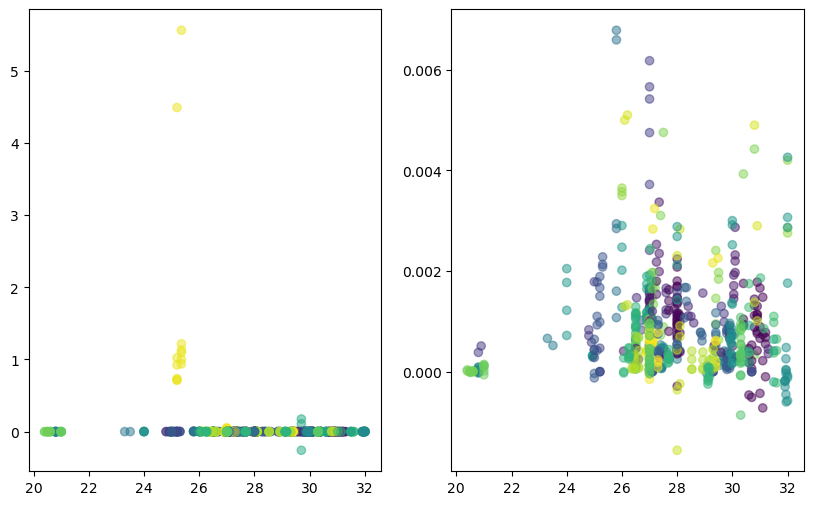

In [334]:
test = carb_df_tgs_no_ones[carb_df_tgs_no_ones.st_calcification_unit == "gCaCO3 cm-2d-1"]

# nsd = 0.1
# mean = test.st_calcification.mean()
# std = test.st_calcification.std()
# test_no_outliers = test[
#     (test.st_calcification > mean - nsd * std) &
#     (test.st_calcification < mean + nsd * std)
# ]
test_no_outliers = test[
    (test.st_calcification > -0.01) &
    (test.st_calcification < 0.01)
]
# exclude values more than 2 SD from the mean

# exclude values more than 2 SD from the mean
# test_no_outliers = test[(test.temp > test.temp.mean() - 2 * test.temp_sd) & (test.temp < test.temp.mean() + 2 * test.temp_sd)]

fig, ax = plt.subplots(1,2,figsize=(10, 6))

ax[0].scatter(
    test.temp,
    test.st_calcification,
    c=test.doi.astype('category').cat.codes,  # Convert DOI to categorical codes for coloring
    alpha=0.5,
    cmap='viridis'  # Optional: specify a colormap
)
# ax[0].set_xlabel('Temperature')
# ax[0].set_ylabel('Standardized Calcification')
# ax[0].set_title('Scatter plot of Standardized Calcification vs Temperature')

ax[1].scatter(
    test_no_outliers.temp,
    test_no_outliers.st_calcification,
    c=test_no_outliers.doi.astype('category').cat.codes,  # Convert DOI to categorical codes for coloring
    alpha=0.5,
    cmap='viridis'  # Optional: specify a colormap
)
# fit a 
# fit a second-order polynomial
# drop nans
test_no_outliers = test_no_outliers.dropna(subset=['temp', 'st_calcification'])
z = np.polyfit(test_no_outliers.temp, test_no_outliers.st_calcification, 2)
p = np.poly1d(z)
# Sort the data by temperature for a smooth line
sorted_temp = np.sort(test_no_outliers.temp)
ax[1].plot(sorted_temp, p(sorted_temp), color='red', label='2nd order polynomial fit')


# plt.plot(test.temp, p(test.temp), color='red', label='2nd order polynomial fit')
# select only 
# plt.scatter(
#     test.temp,
#     test.st_calcification,
#     c=test.doi.astype('category').cat.codes,  # Convert DOI to categorical codes for coloring
#     alpha=0.5,
#     cmap='viridis'  # Optional: specify a colormap
# )
# plt.colorbar(label='DOI (categorical)')
# plt.xlabel('Temperature')
# plt.ylabel('Standardized Calcification')
# plt.title('Scatter plot of Standardized Calcification vs Temperature')
# plt.ylim(-0.005,0.005)
# # fit a second-order polynomial
# z = np.polyfit(test.temp, test.st_calcification, 2)
# p = np.poly1d(z)
# plt.plot(test.temp, p(test.temp), color='red', label='2nd order polynomial fit')


In [335]:
test_no_outliers.columns

Index(['authors', 'calcification', 'calcification_sd', 'calcification_se',
       'calcification_unit', 'cleaned_coords', 'co3', 'co3_sd', 'co3_se',
       'coords', 'core_grouping', 'dic', 'dic_sd', 'dic_se', 'do', 'do_sd',
       'do_se', 'doi', 'duration', 'ecoregion', 'extractor', 'family',
       'functional_group', 'genus', 'hco3', 'hco3_sd', 'hco3_se', 'hplus',
       'include', 'index_right', 'ipar', 'ipar_sd', 'ipar_se', 'irr',
       'irr_group', 'irr_sd', 'irr_se', 'lat_zone', 'latitude', 'life_stages',
       'loc', 'location', 'location_lower', 'longitude', 'methods', 'n',
       'notes', 'notes+', 'notes++', 'omegaa', 'omegaa_sd', 'omegaa_se',
       'omegac', 'omegac_sd', 'omegac_se', 'original_doi', 'pco2', 'pco2_sd',
       'pco2_se', 'phnbs', 'phnbs_sd', 'phnbs_se', 'phtot', 'phtot_sd',
       'phtot_se', 'realm', 'sal', 'sal_sd', 'sal_se', 'secondary_check',
       'species', 'species_types', 'st_calcification', 'st_calcification_sd',
       'st_calcification_unit', 

In [ ]:

# min

# points_weights = points_weights / points_weights.sum()
# points_weights.describe()

In [308]:
points_weights

0       1.000571
1       1.000424
2       1.000375
3       1.000277
4       1.000294
          ...   
1576    1.000389
1577    1.000337
1578    1.000272
1579    1.000289
1580    1.000398
Name: st_calcification_sd, Length: 417, dtype: float64

In [ ]:
test_no_outliers['st_calcification_sd'] *10

0       1.000571
1       1.000424
2       1.000375
3       1.000277
4       1.000294
          ...   
1576    1.000389
1577    1.000337
1578    1.000272
1579    1.000289
1580    1.000398
Name: st_calcification_sd, Length: 417, dtype: float64

In [318]:
# plot an interactive 3d plot with calcification on the z axis, and temperature/phtot on the x/y axis

import plotly.express as px



# create helper column to weight points by the inverse of their standard deviation
# points_weights = 1/test['st_calcification_sd']

test_no_outliers['points_weights'] = np.sqrt(test_no_outliers['st_calcification_sd'])

px.scatter_3d(
    test_no_outliers,
    x='temp',
    y='phtot',
    z='st_calcification',
    color='core_grouping',
    title='3D Scatter plot of Standardized Calcification vs Temperature and pH',
    labels={'temp': 'Temperature', 'phtot': 'pH', 'st_calcification': 'Standardized Calcification'},
    hover_name='species_types',
    opacity=0.5,
    size='points_weights',
    # size_max=1,
    # increase figsize
    width=800,
    height=800,
)


In [340]:
# Ensure no NaN values in temp, phtot, st_calcification, and st_calcification_sd
test_no_outliers = test_no_outliers.dropna(subset=['temp', 'phtot', 'st_calcification', 'st_calcification_sd'])

# Create a grid of points
x_grid = np.linspace(test_no_outliers.temp.min(), test_no_outliers.temp.max(), 50)
y_grid = np.linspace(test_no_outliers.phtot.min(), test_no_outliers.phtot.max(), 50)
X, Y = np.meshgrid(x_grid, y_grid)

# Calculate weights as the inverse of st_calcification_sd
weights = 1 / test_no_outliers.st_calcification_sd

# Interpolate the Z values (st_calcification) on the grid using weights
Z = griddata(
    (test_no_outliers.temp, test_no_outliers.phtot),
    test_no_outliers.st_calcification,
    (X, Y),
    method='linear',
    rescale=False
)

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(
    title='3D Surface Plot of Standardized Calcification vs Temperature and pH (Weighted)',
    scene=dict(
        xaxis_title='Temperature',
        yaxis_title='pH',
        zaxis_title='Standardized Calcification'
    ),
    width=800,
    height=800,
)
fig.show()


In [295]:
from sklearn.kernel_ridge import KernelRidge

# Create a grid of points
x_grid = np.linspace(test_no_outliers.temp.min(), test_no_outliers.temp.max(), 100)
y_grid = np.linspace(test_no_outliers.phtot.min(), test_no_outliers.phtot.max(), 100)
X, Y = np.meshgrid(x_grid, y_grid)



# Create and fit the model with sample weights
kr = KernelRidge(alpha=1.0, kernel='rbf')
kr.fit(
    np.column_stack((test_no_outliers.temp, test_no_outliers.phtot)),
    test_no_outliers.st_calcification,
    sample_weight=weights
)

# Predict on the grid
Z = kr.predict(np.column_stack((X.ravel(), Y.ravel()))).reshape(X.shape)

# Create a 3D surface plot
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(
    title='3D Surface Plot of Standardized Calcification vs Temperature and pH (Weighted)',
    scene=dict(
        xaxis_title='Temperature',
        yaxis_title='pH',
        zaxis_title='Standardized Calcification'
    ),
    width=800,
    height=800,
)
fig.show()

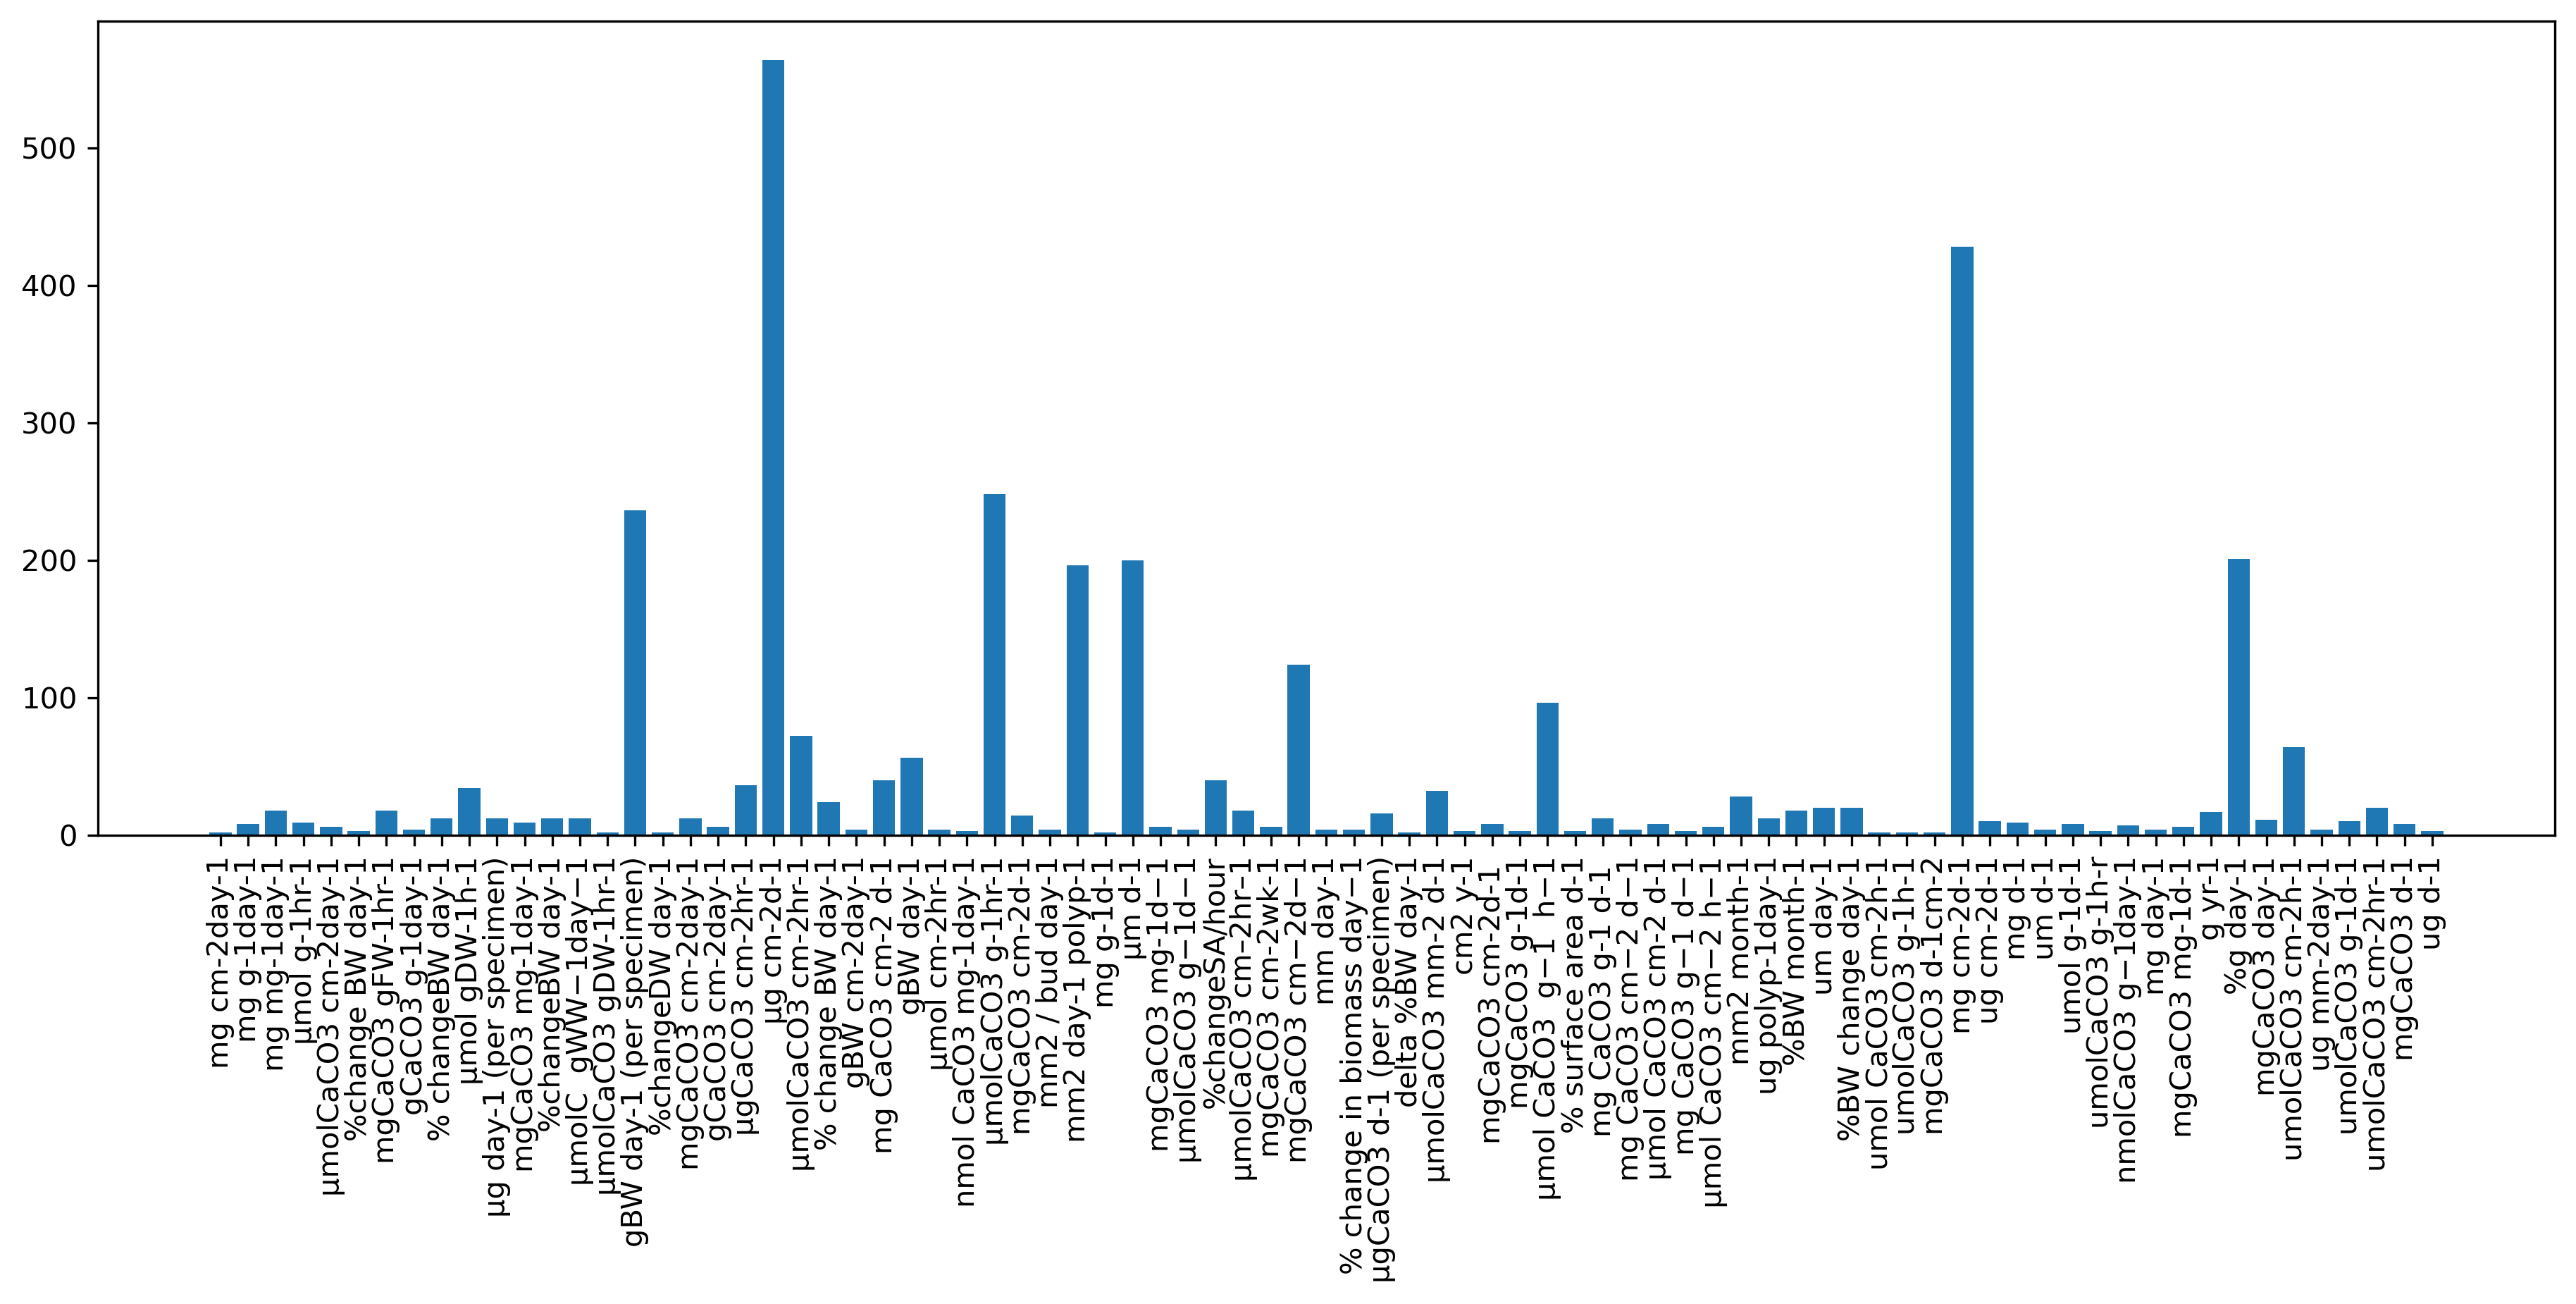

In [80]:
# plot a bar chart with the number of calcification units per treatment unit
fig, ax = plt.subplots(figsize=(15, 5), dpi=300)
ax.bar(
    range(carb_df['calcification_unit'].nunique()), 
    carb_df.groupby('calcification_unit').size(), 
    tick_label=carb_df['calcification_unit'].dropna().unique()
)
plt.xticks(rotation=90);
# plt.xlabel('Calcification Unit')

In [81]:
carb_units_df = carb_df.copy().drop_duplicates(subset=['calcification_unit'], keep='first')[['calcification', 'calcification_sd', 'calcification_unit', 'st_calcification_unit']]
carb_units_df[['st_calcification', 'st_calcification_sd', 'st_calcification_unit']] = carb_units_df.apply(
# carb_units_df.apply(
        lambda x: pd.Series(utils.rate_conversion(x['calcification'], x['calcification_sd'], x['st_calcification_unit'])) if pd.notna(x['calcification']) and pd.notna(x['calcification_unit']) else pd.Series(['', '', '']), 
        axis=1)

# send carb_units_df['st_calcification'] to floats
carb_units_df['st_calcification'] = pd.to_numeric(carb_units_df['st_calcification'], errors='coerce')

carb_units_df['scaling_factor'] = carb_units_df.apply(
        lambda row: row['st_calcification'] / row['calcification'] if row['calcification'] != 0 else np.nan,
        axis=1
)
carb_units_df.st_calcification_unit.value_counts()

st_calcification_unit
gCaCO3 cm-2d-1    26
gCaCO3 g-1d-1     24
g d-1             11
deltaMass d-1     10
m2 d-1             4
m d-1              4
deltaSA d-1        2
                   1
Name: count, dtype: int64

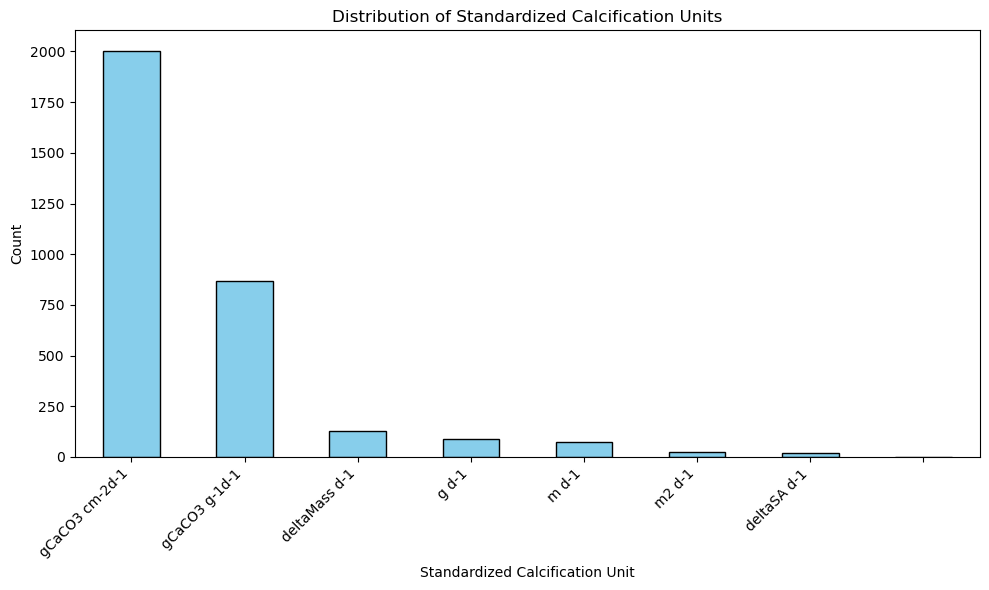

In [82]:
carb_units_df = carb_df.copy()
carb_units_df[['st_calcification', 'st_calcification_sd', 'st_calcification_unit']] = carb_units_df.apply(
# carb_units_df.apply(
        lambda x: pd.Series(utils.rate_conversion(x['calcification'], x['calcification_sd'], x['st_calcification_unit'])) if pd.notna(x['calcification']) and pd.notna(x['calcification_unit']) else pd.Series(['', '', '']), 
        axis=1)

# send carb_units_df['st_calcification'] to floats
carb_units_df['st_calcification'] = pd.to_numeric(carb_units_df['st_calcification'], errors='coerce')

carb_units_df['scaling_factor'] = carb_units_df.apply(
        lambda row: row['st_calcification'] / row['calcification'] if row['calcification'] != 0 else np.nan,
        axis=1
)

# Get the value counts
value_counts = carb_units_df.st_calcification_unit.value_counts()

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 6))
value_counts.plot(kind='bar', ax=ax, color='skyblue', edgecolor='black')

# Add labels and title
ax.set_xlabel('Standardized Calcification Unit')
ax.set_ylabel('Count')
ax.set_title('Distribution of Standardized Calcification Units')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

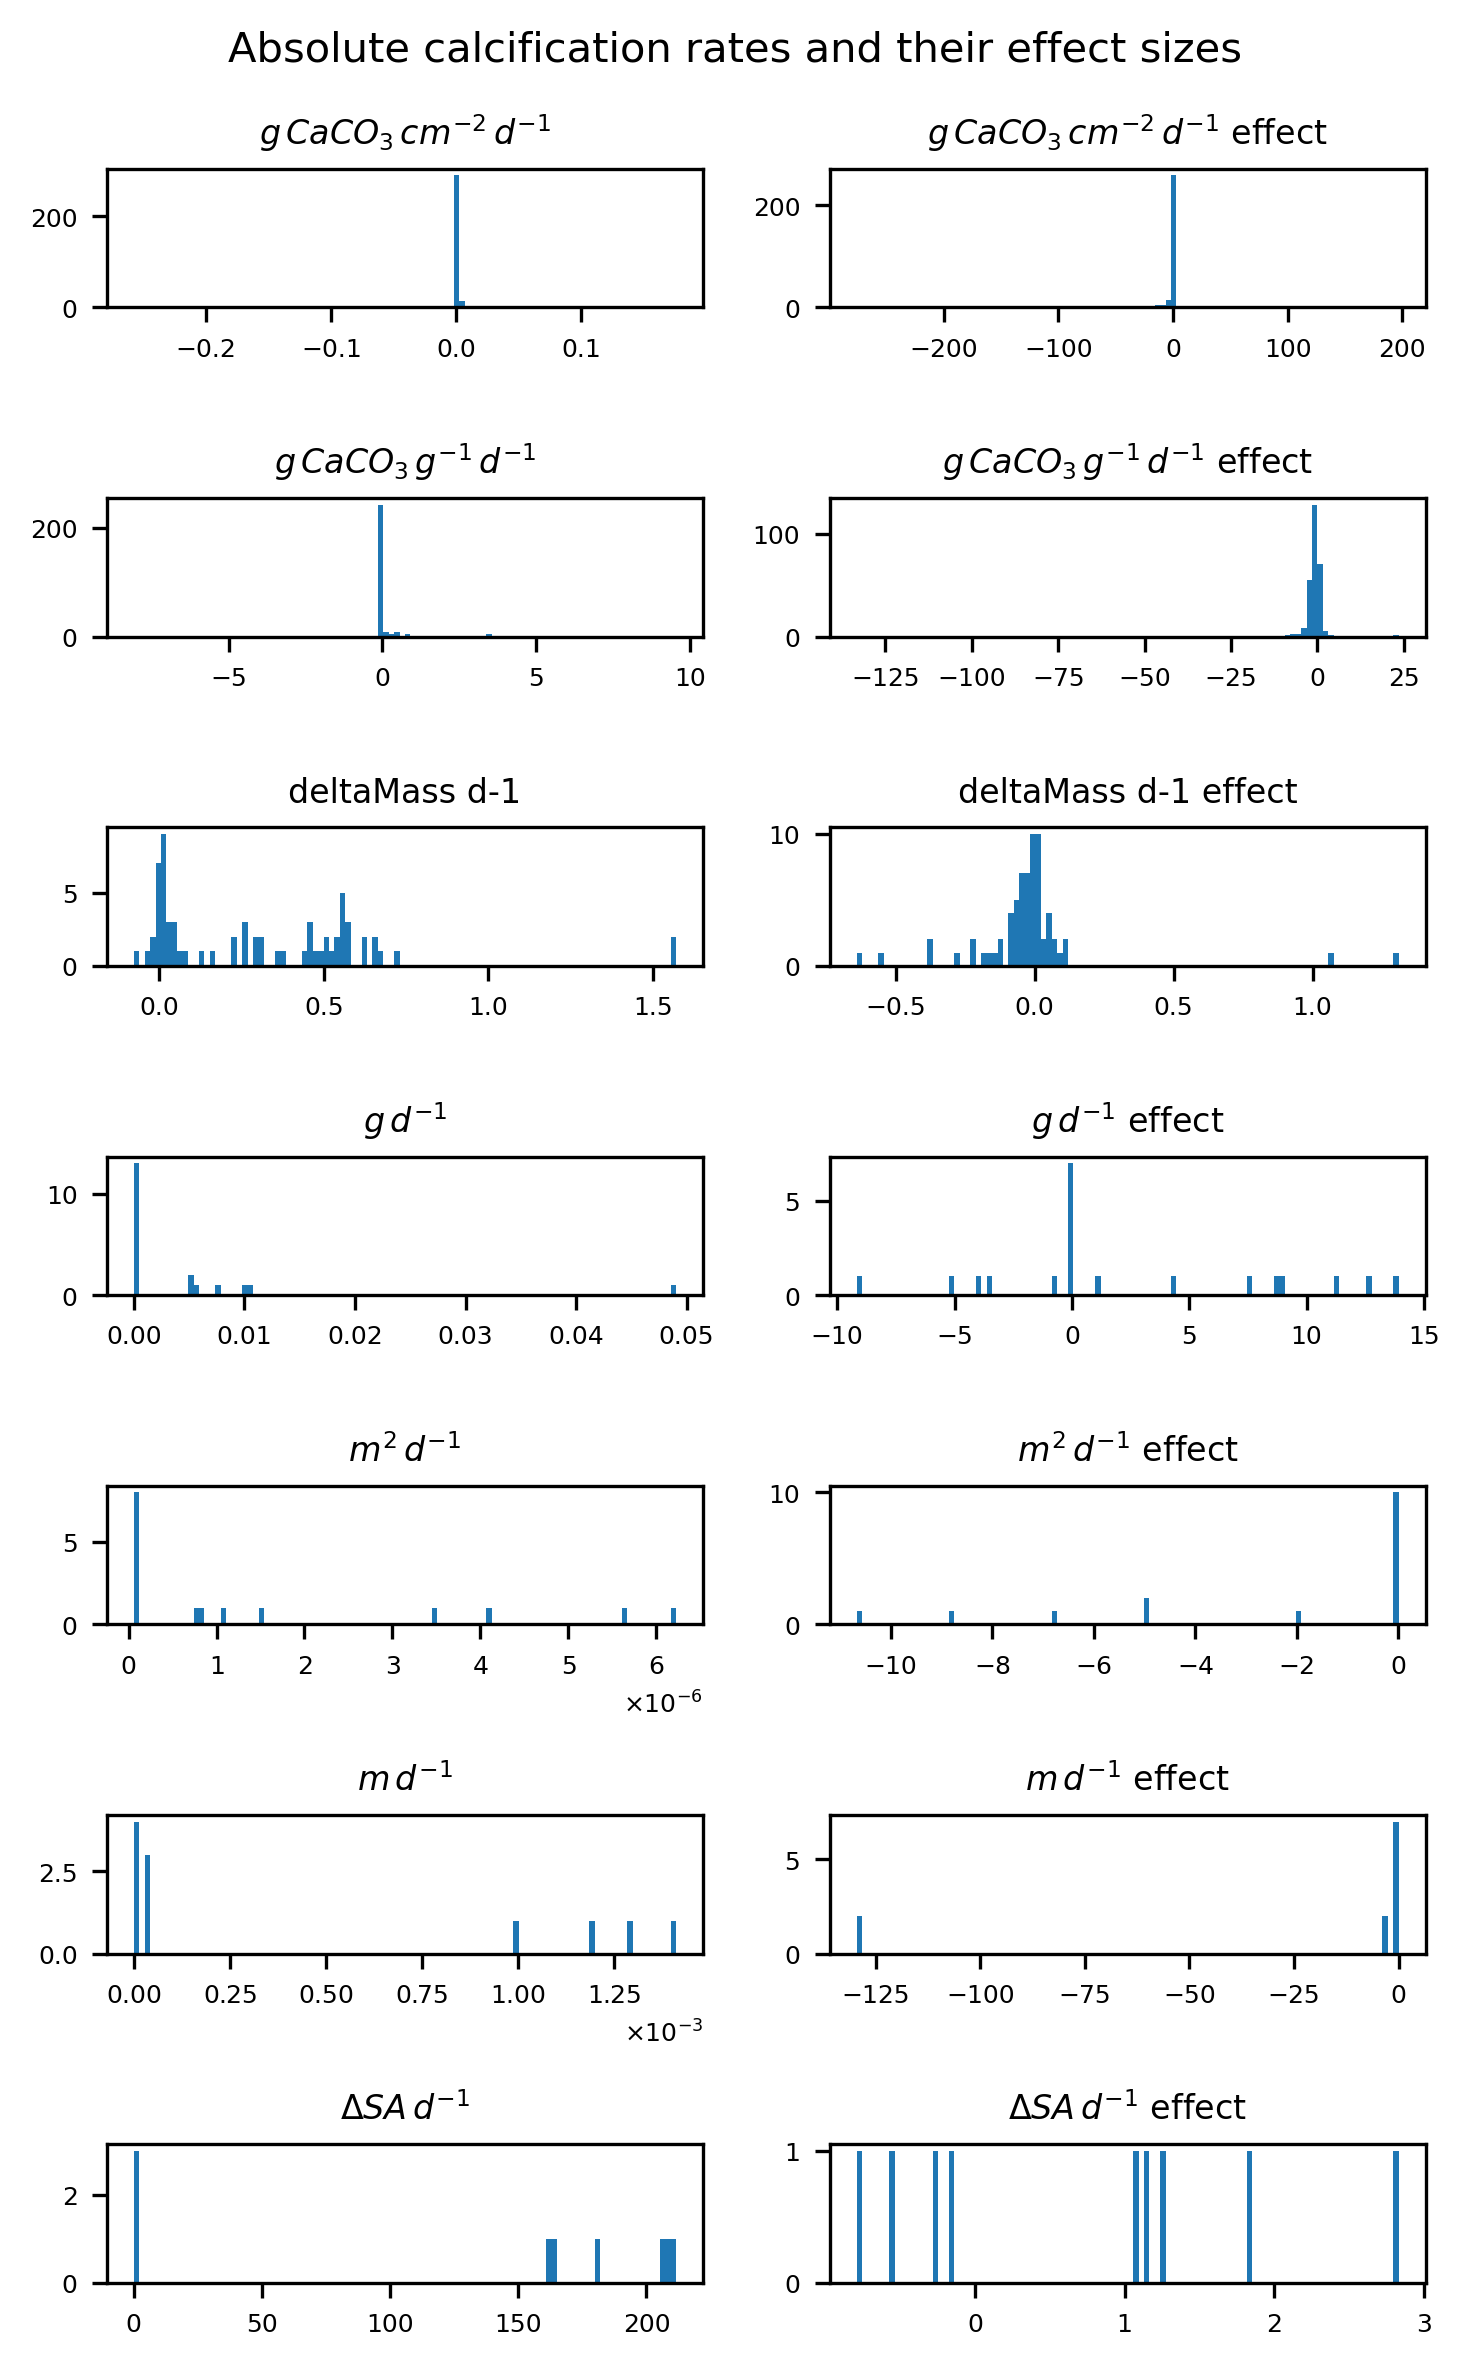

In [25]:
### visualise distributions of various calcification rates
rate_type_mapping = {
    'gCaCO3 cm-2d-1': r'$g \, CaCO_3 \, cm^{-2} \, d^{-1}$',
    'gCaCO3 g-1d-1': r'$g \, CaCO_3 \, g^{-1} \, d^{-1}$',
    'delta mass d-1': r'$\Delta mass\, d^{-1}$',
    'g d-1': r'$g \, d^{-1}$',
    'm2 d-1': r'$m^2 \, d^{-1}$',
    'm d-1': r'$m \, d^{-1}$',
    'deltaSA d-1': r'$\Delta SA \, d^{-1}$'
}

rate_types = results_df['st_calcification_unit'].unique()
rate_types = [rate_type for rate_type in rate_types if rate_type != ""]
fig, axes = plt.subplots(len(rate_types), 2, figsize=(5, 8), dpi=300)

for i, rate_type in tqdm(enumerate(rate_types), total=len(rate_types)):
    # absolute calcification
    axes[i][0].hist(results_df[results_df['st_calcification_unit'] == rate_type]['st_calcification'], bins=100)
    axes[i][0].set_title(rate_type_mapping.get(rate_type, rate_type), fontsize=8)
    # absolute effect sizes
    axes[i][1].hist(results_df[results_df['st_calcification_unit'] == rate_type]['absolute_calcification'], bins=100)
    axes[i][1].set_title(f"{rate_type_mapping.get(rate_type, rate_type)} effect", fontsize=8)
    
# format
for ax in axes.flatten():
    ax.tick_params(axis='both', which='major', labelsize=6)
    if ax.get_xlim()[1] < 0.01:
        ax.ticklabel_format(style='scientific', axis='x', scilimits=(0, 0), useMathText=True)
        ax.xaxis.get_offset_text().set_fontsize(6)
    
plt.suptitle('Absolute calcification rates and their effect sizes', fontsize=10)
plt.tight_layout()

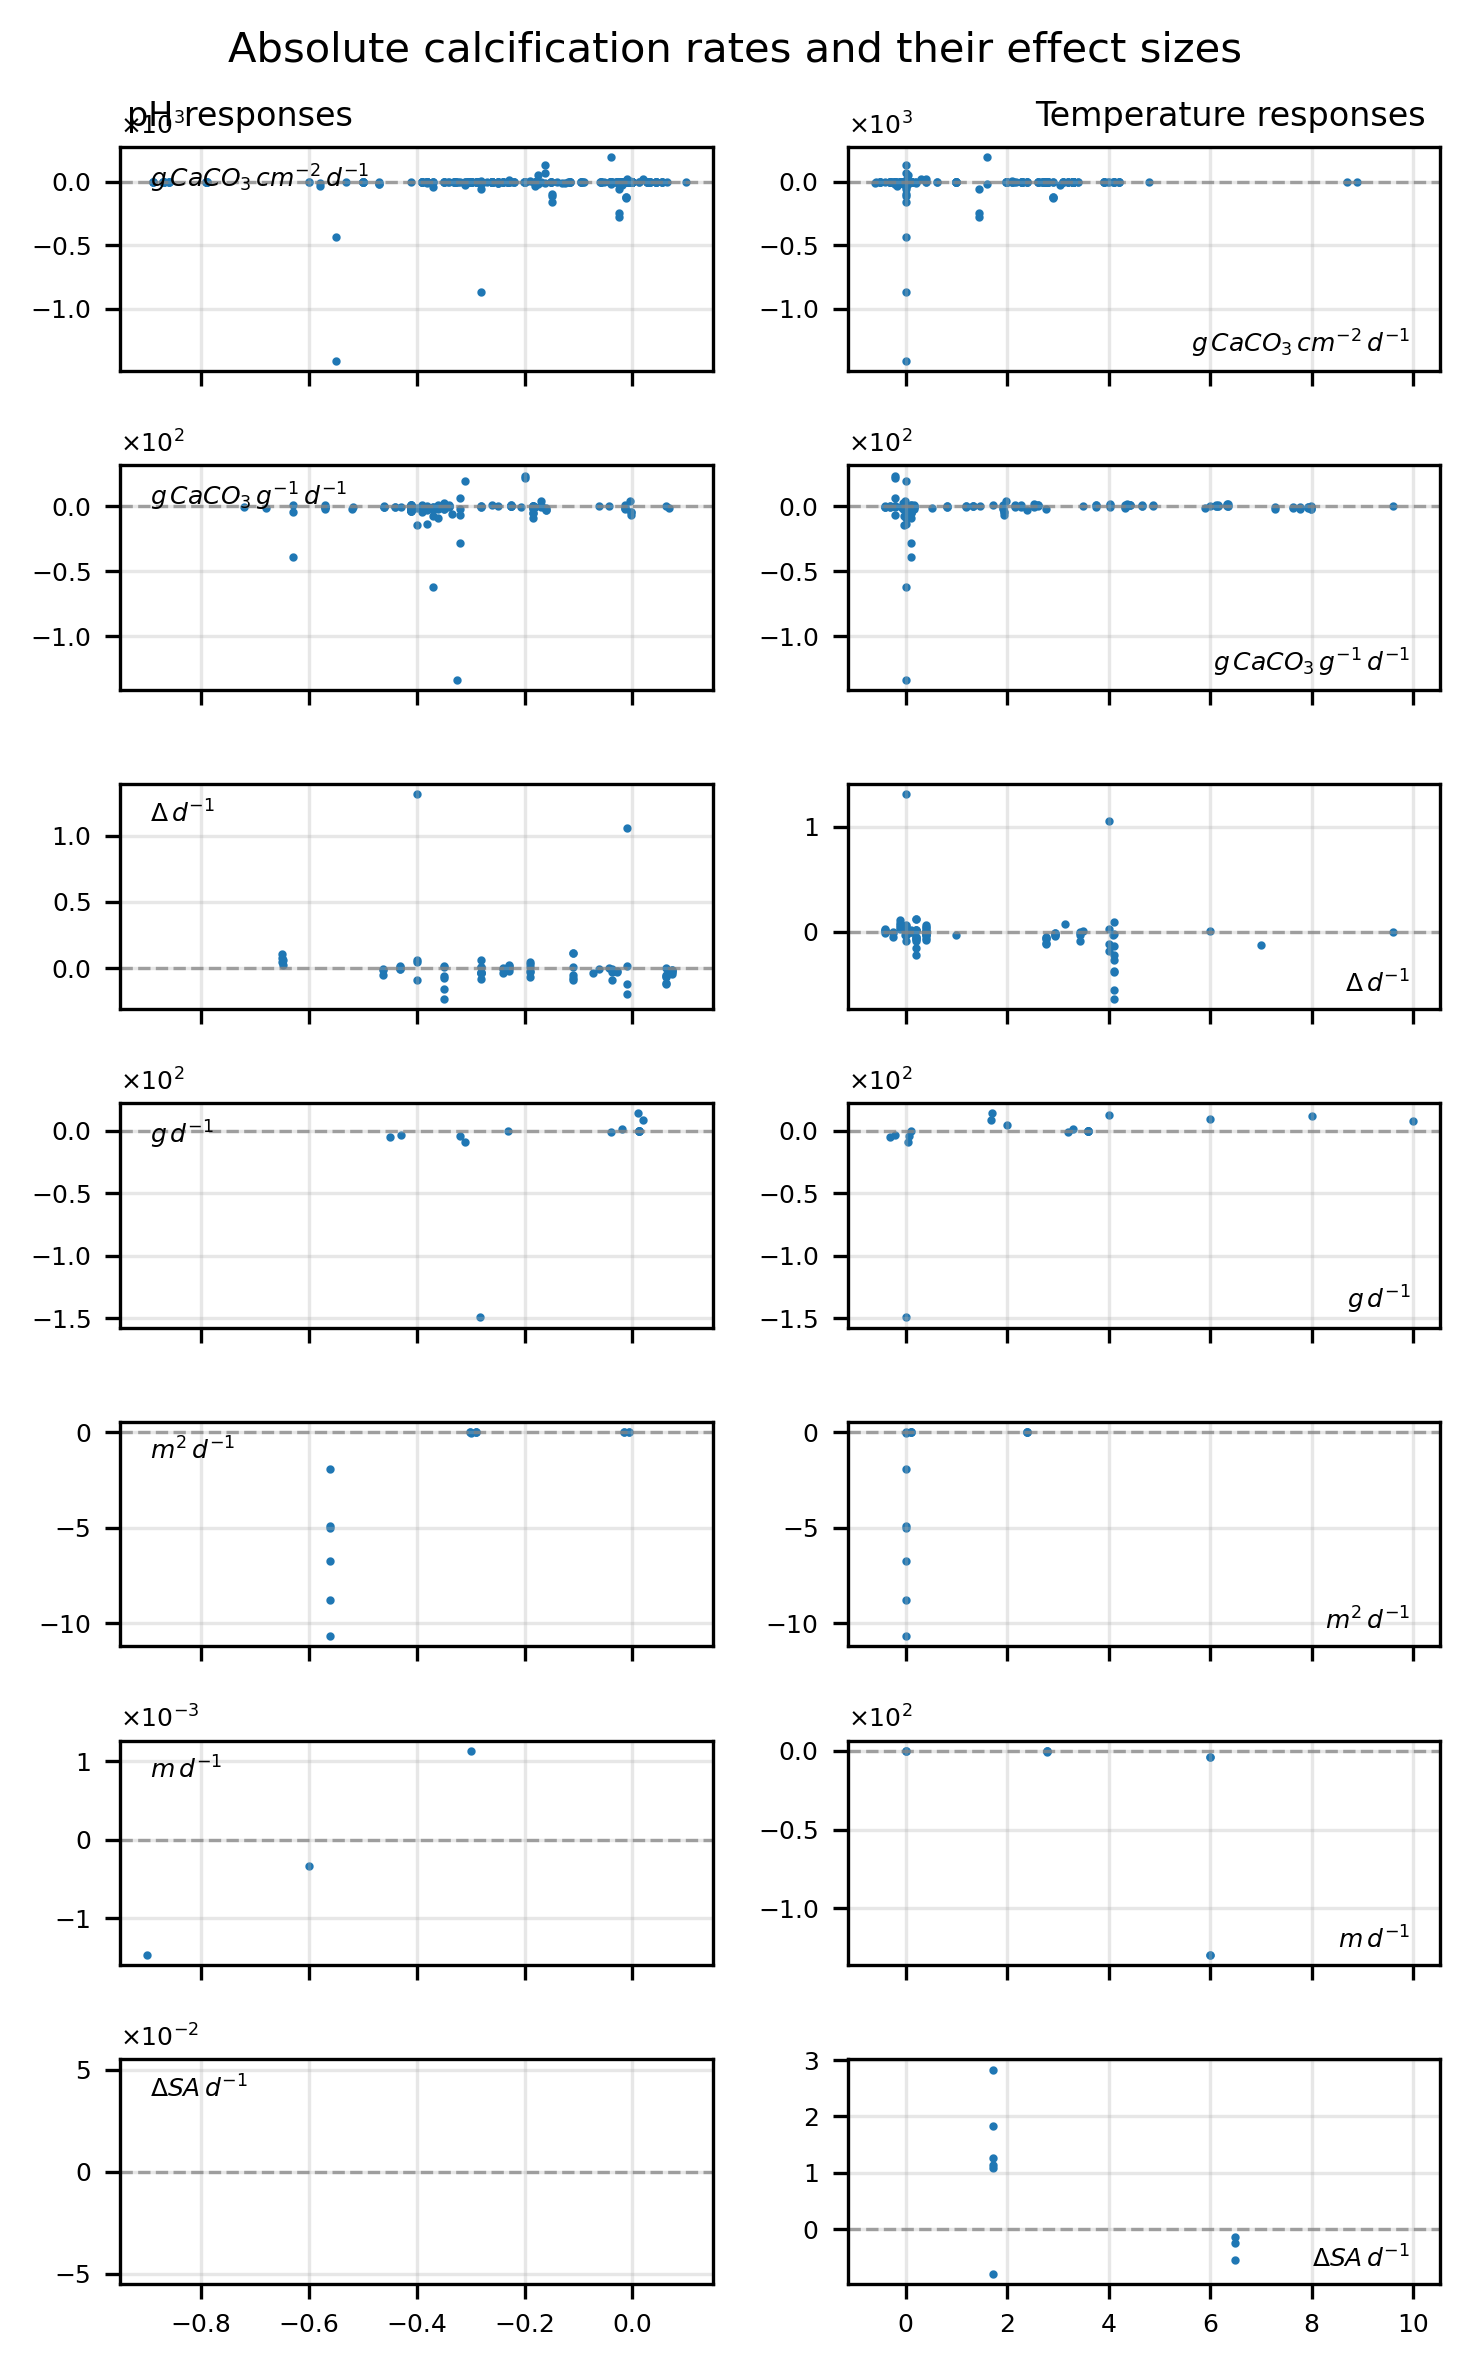

In [231]:
fig, axes = plt.subplots(len(rate_types), 2, figsize=(5, 8), dpi=300)

# Create shared x axes within columns
for col in range(2):
    for i in range(1, len(rate_types)):
        axes[i, col].sharex(axes[0, col])

for i, rate_type in enumerate(rate_types):
    rate_df = results_df[results_df['st_calcification_unit'] == rate_type]
    
    # pH
    axes[i][0].scatter(rate_df['delta_ph'], rate_df['absolute_calcification'], s=1)
    # Add rate_type in top left
    axes[i][0].text(0.05, 0.93, rate_type_mapping.get(rate_type, rate_type), 
                   transform=axes[i][0].transAxes, fontsize=6, 
                   va='top', ha='left')
    
    # temperature
    axes[i][1].scatter(rate_df['delta_t'], rate_df['absolute_calcification'], s=1)
    axes[i][1].text(0.95, 0.05, rate_type_mapping.get(rate_type, rate_type), 
                   transform=axes[i][1].transAxes, fontsize=6, 
                   va='bottom', ha='right')

# label each column
fig.text(0.17, 0.94, 'pH responses', ha='center', fontsize=8)
fig.text(0.83, 0.94, 'Temperature responses', ha='center', fontsize=8)

for ax in axes.flatten():
    ax.set_title('')
    ax.grid(visible=True, alpha=0.3)
    # zero effect line
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.7, linewidth=0.8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    # ax.set_yscale('symlog')    
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(-2, 2), useMathText=True)
    ax.yaxis.get_offset_text().set_fontsize(6)
    
# clear x tick labels for all but the bottom row of plots
for i in range(len(rate_types)-1):
    axes[i, 0].tick_params(axis='x', labelbottom=False)
    axes[i, 1].tick_params(axis='x', labelbottom=False)

plt.suptitle('Absolute calcification rates and their effect sizes', fontsize=10)
plt.tight_layout()

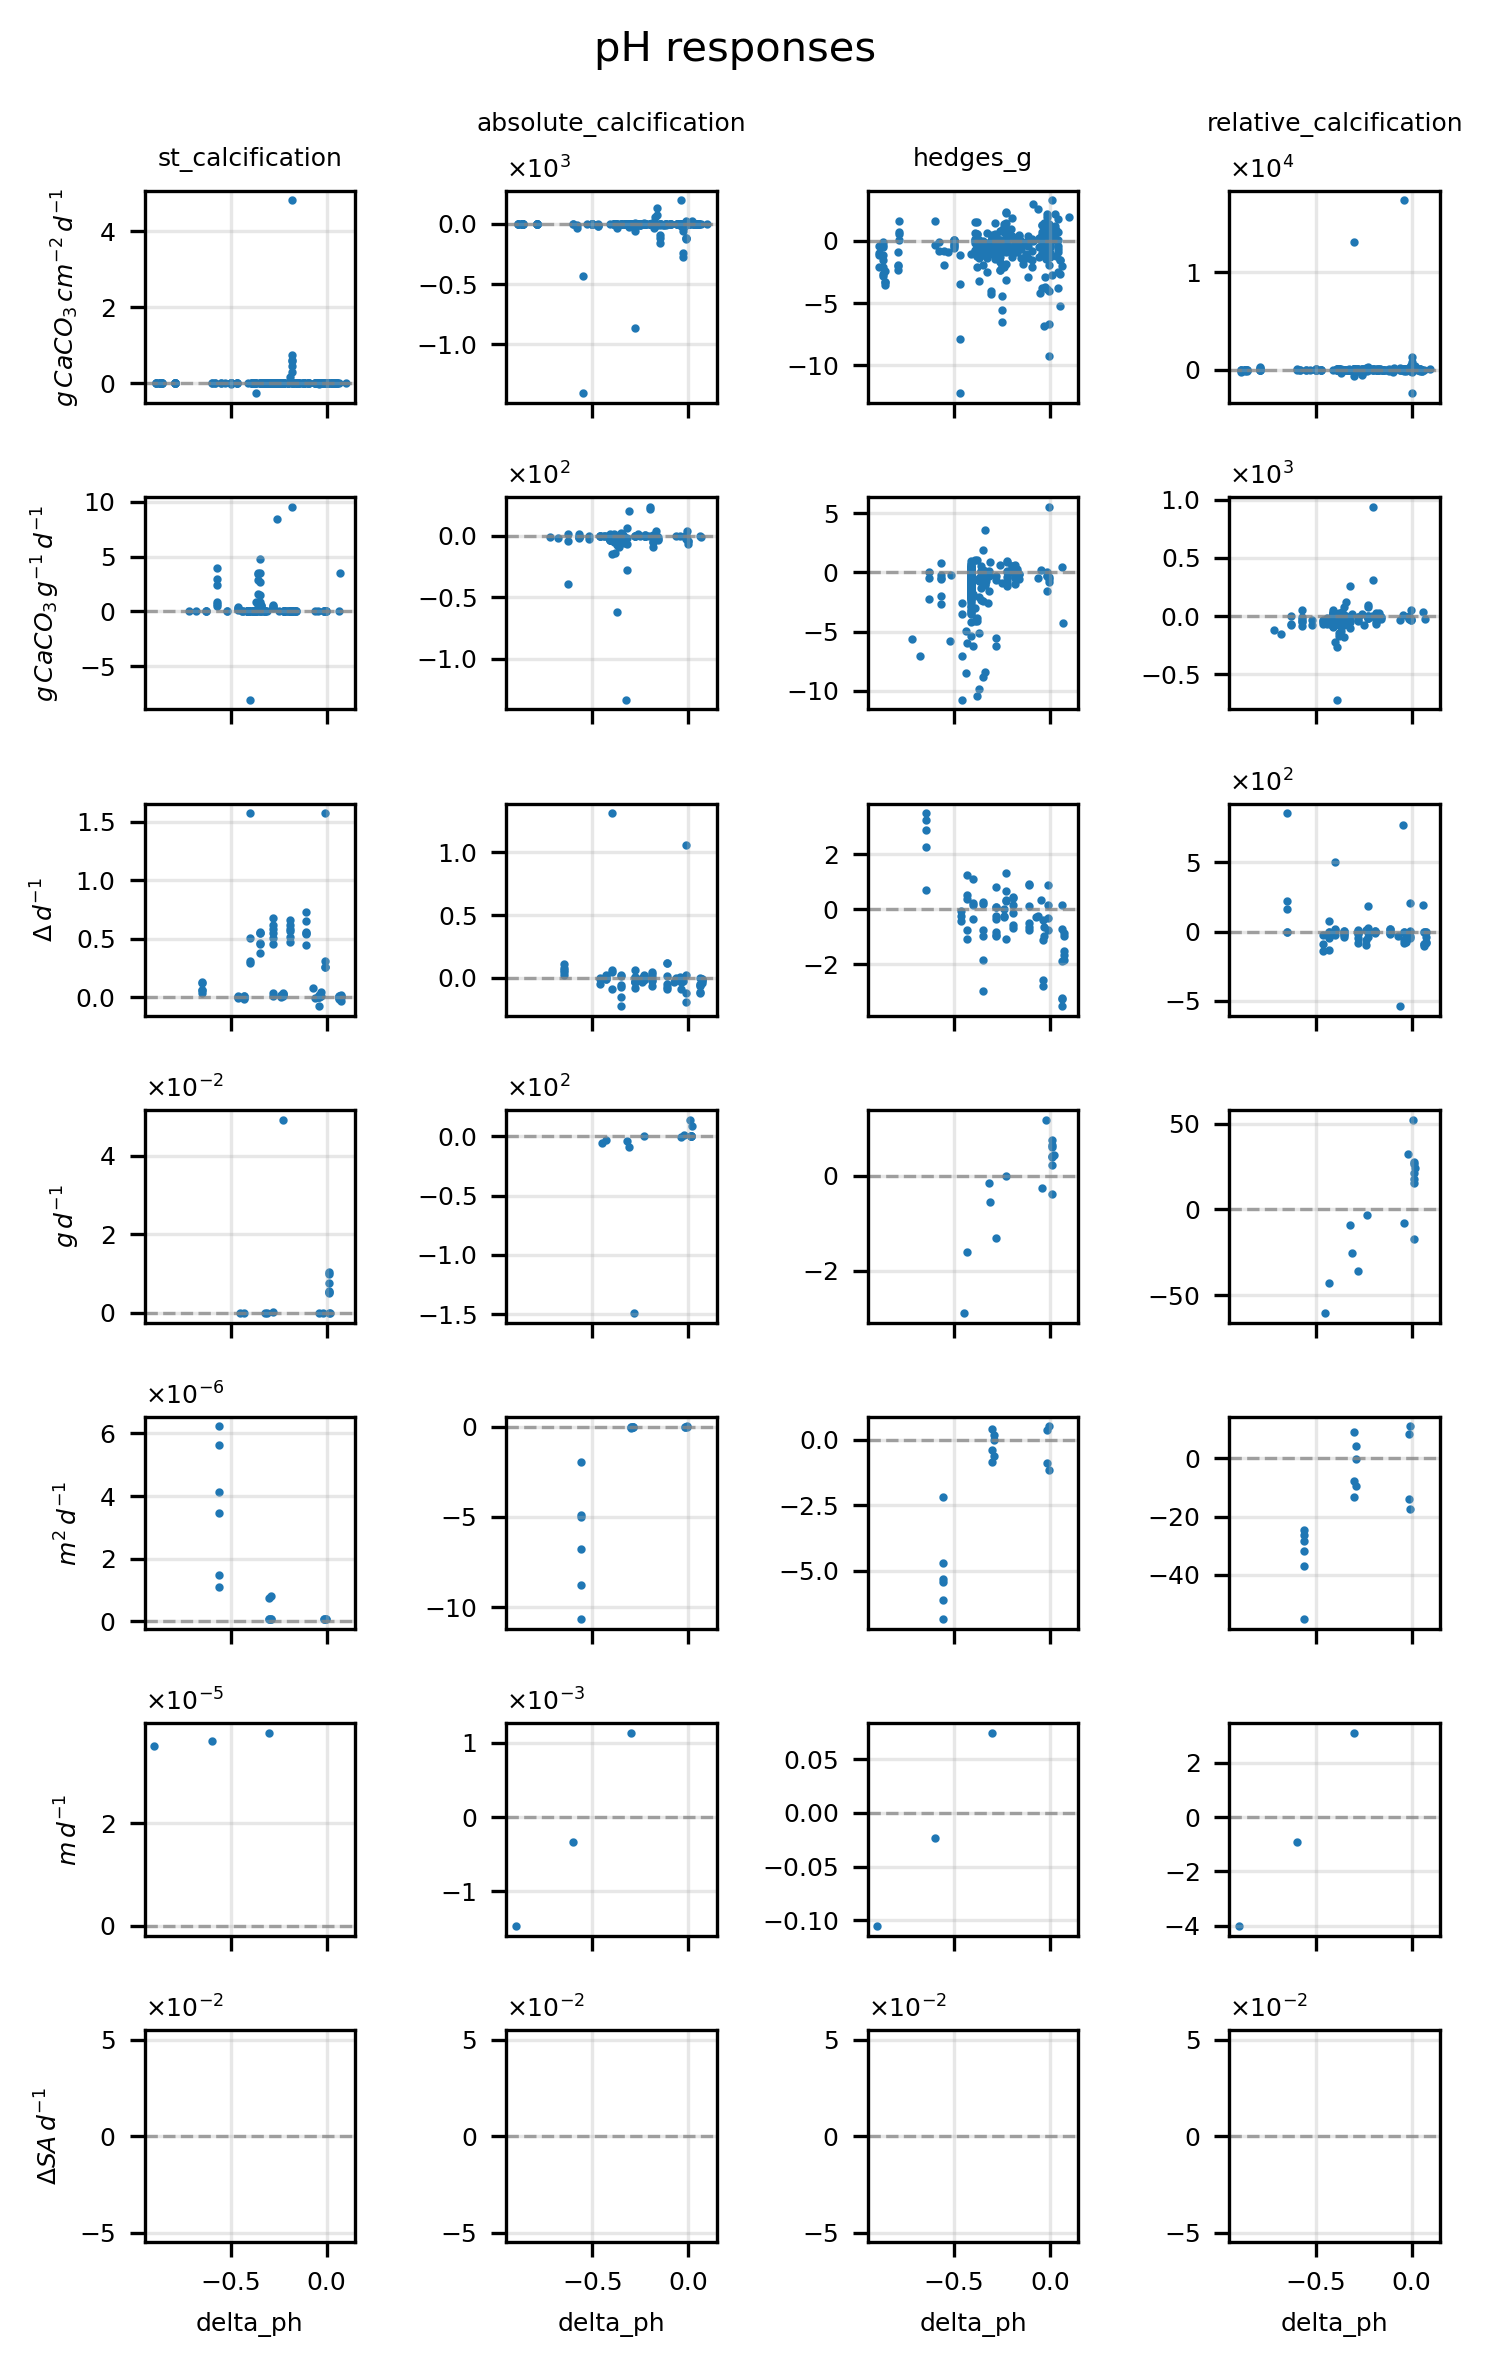

In [223]:
_,_ = plotting.plot_effect_size_grid(
    results_df,
    rate_types,
    x_var='delta_ph',
    y_vars=['st_calcification', 'absolute_calcification', 'hedges_g', 'relative_calcification'],
    col_titles=['st_calcification', 'absolute_calcification', 'hedges_g', 'relative_calcification'],
    rate_type_mapping=rate_type_mapping,
    figure_title='pH responses',
    figsize=(5, 8),
    dpi=300,
    s=1
)

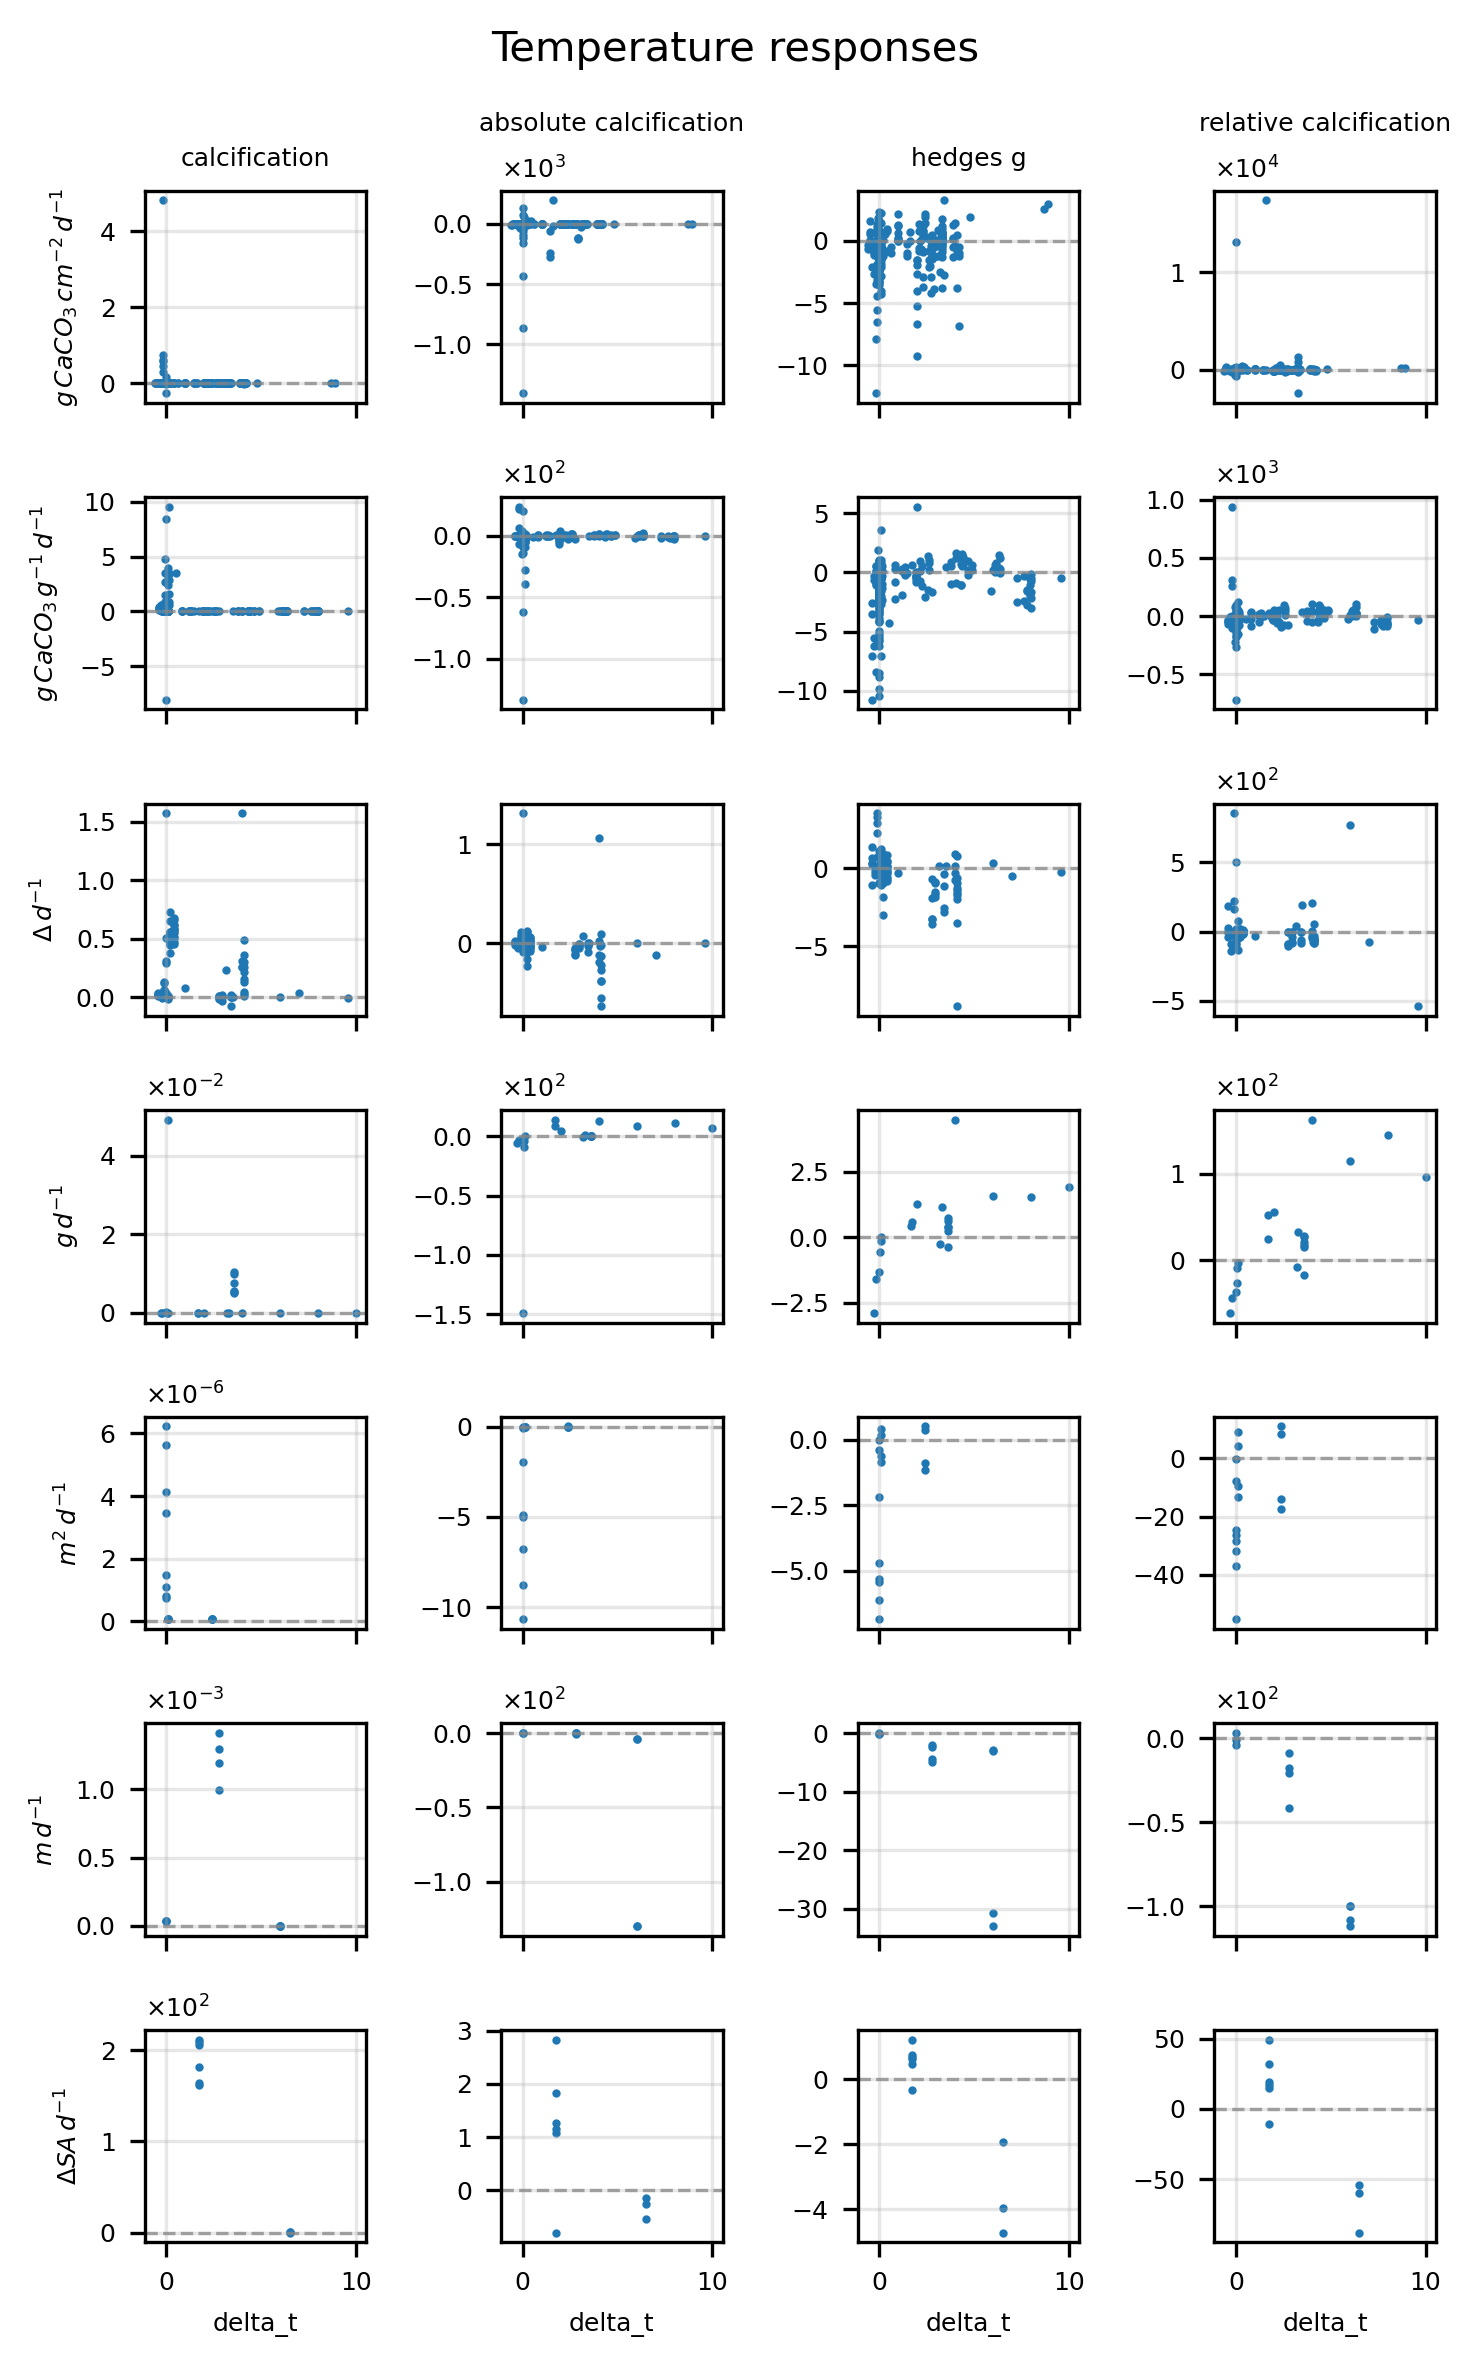

In [224]:
_,_ = plotting.plot_effect_size_grid(
    results_df,
    rate_types,
    x_var='delta_t',
    y_vars=['st_calcification', 'absolute_calcification', 'hedges_g', 'relative_calcification'],
    col_titles=['calcification', 'absolute calcification', 'hedges g', 'relative calcification'],
    rate_type_mapping=rate_type_mapping,
    figure_title='Temperature responses',
    figsize=(5, 8),
    dpi=300,
    s=1
)

## Investigating relationship between relative calcification rate and Hedges G

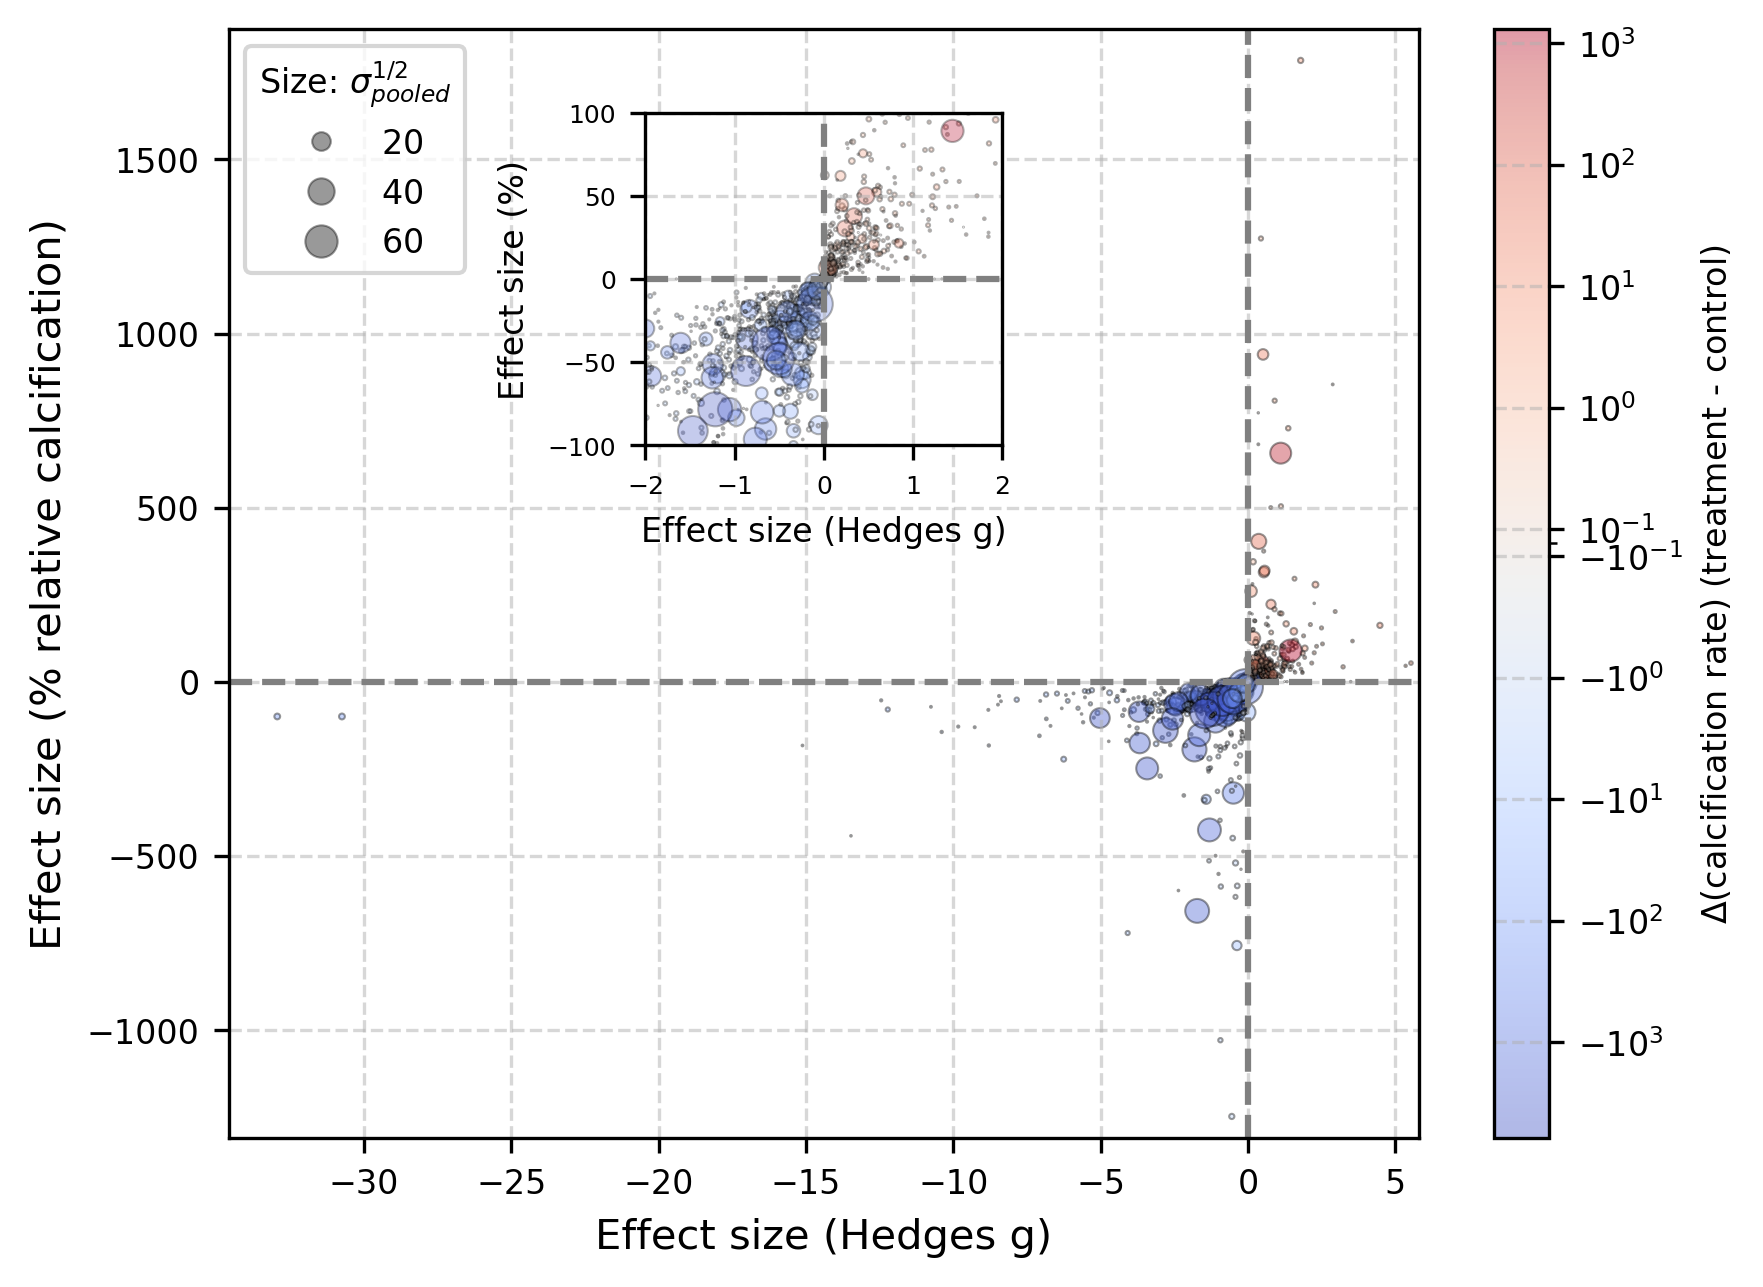

In [247]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors

# Cross-plot of Hedges g and relative calcification
fig, ax = plt.subplots(dpi=300)

# Filter outliers and drop NaN values
num_std_devs = 1
outliers = results_df[
    (results_df.relative_calcification > results_df.relative_calcification.mean() + num_std_devs * results_df.relative_calcification.std()) |
    (results_df.relative_calcification < results_df.relative_calcification.mean() - num_std_devs * results_df.relative_calcification.std())
]
results_df_no_outliers = results_df.loc[~results_df.index.isin(outliers.index)].dropna(subset=['hedges_g', 'relative_calcification'])

# Logarithmic normalization for color scale
norm = colors.SymLogNorm(linthresh=0.1, linscale=0.1, 
                         vmin=results_df_no_outliers.absolute_calcification.min(), 
                         vmax=results_df_no_outliers.absolute_calcification.max())

# Compute pooled standard deviation
sd_pooled = np.sqrt(
    ((results_df_no_outliers.control_n - 1) * results_df_no_outliers.control_calcification_sd**2 +
     (results_df_no_outliers.treatment_n - 1) * results_df_no_outliers.treatment_calcification_sd**2) /
    (results_df_no_outliers.control_n + results_df_no_outliers.treatment_n - 2)
)

# Scatter plot
scat = ax.scatter(
    results_df_no_outliers.hedges_g, results_df_no_outliers.relative_calcification,
    c=results_df_no_outliers.absolute_calcification, norm=norm, cmap='coolwarm',
    alpha=0.4, s=np.sqrt(sd_pooled), edgecolor='k', linewidth=0.5
)

# Add zero effect lines
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0, color='grey', linestyle='--')

# Add legend for sizes
ax.legend(*scat.legend_elements("sizes", num=4), title=r"Size: $\sigma_{pooled}^{1/2}$", loc='upper left', fontsize=8, title_fontsize=8)

# Add colorbar
cbar = plt.colorbar(scat, ax=ax)
cbar.ax.tick_params(labelsize=8)
cbar.set_label(r'$\Delta$(calcification rate) (treatment - control)', fontsize=8)
cbar.set_ticks(cbar.get_ticks()[cbar.get_ticks() != 0])  # Remove 0 from colorbar ticks

# Set axis limits and labels
ax.set_xlim(results_df_no_outliers.hedges_g.min() * 1.05, results_df_no_outliers.hedges_g.max() * 1.05)
ax.set_ylim(results_df_no_outliers.relative_calcification.min() * 1.05, results_df_no_outliers.relative_calcification.max() * 1.05)
ax.set_xlabel('Effect size (Hedges g)')
ax.set_ylabel('Effect size (% relative calcification)')

# Inset plot
inset_ax = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=2)
inset_ax.scatter(
    results_df_no_outliers.hedges_g, results_df_no_outliers.relative_calcification,
    c=results_df_no_outliers.absolute_calcification, norm=norm, cmap='coolwarm',
    alpha=0.3, s=np.sqrt(sd_pooled), edgecolor='k', linewidth=0.5
)
inset_ax.axhline(0, color='grey', linestyle='--')
inset_ax.axvline(0, color='grey', linestyle='--')
inset_ax.set_xlim(-2, 2)
inset_ax.set_ylim(-100, 100)
inset_ax.set_xlabel('Effect size (Hedges g)', fontsize=8)
inset_ax.set_ylabel('Effect size (%)', fontsize=8)
inset_ax.tick_params(axis='both', which='major', labelsize=6)

# Add grid to all axes
for a in fig.axes:
    a.grid(True, linestyle='--', alpha=0.5)

ax.tick_params(labelsize=8)


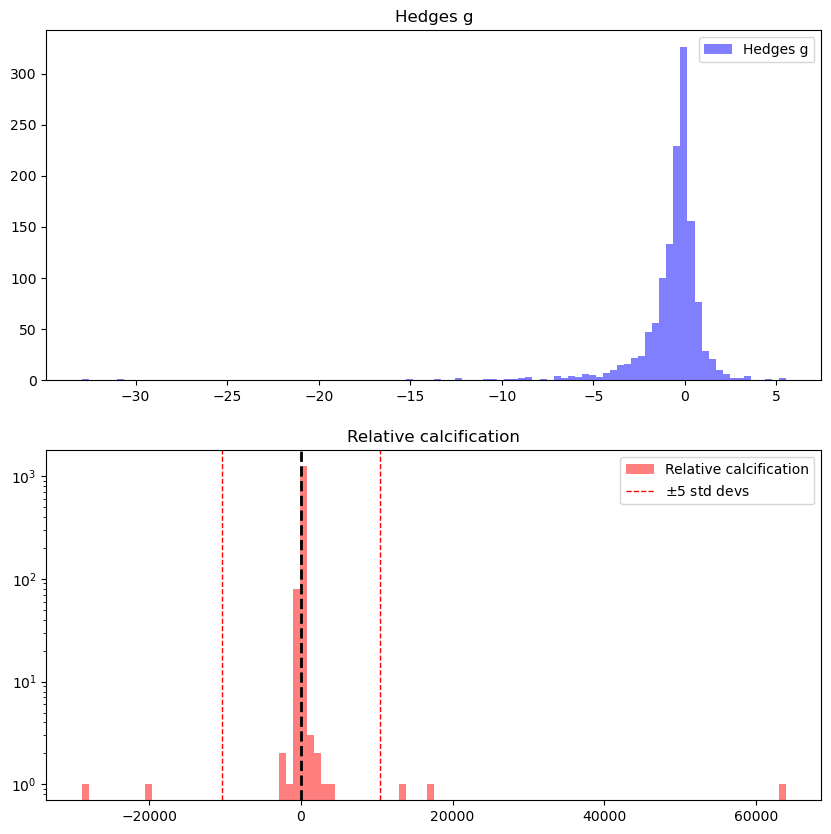

In [249]:
fig, (ax_hedges, ax_relative) = plt.subplots(2,1, figsize=(10,10))

bins = 100
ax_hedges.hist(results_df.hedges_g, bins=bins, alpha=0.5, color='blue', label='Hedges g')
ax_relative.hist(results_df.relative_calcification, bins=bins, alpha=0.5, color='red', label='Relative calcification')
ax_hedges.set_title('Hedges g')
ax_relative.set_title('Relative calcification')
ax_relative.set_yscale('log')

num_std_devs = 5
# determine outliers in relative_calcification (+- 3 std devs)
outliers = results_df[(results_df.relative_calcification > results_df.relative_calcification.mean() + num_std_devs*results_df.relative_calcification.std()) | (results_df.relative_calcification < results_df.relative_calcification.mean() - num_std_devs*results_df.relative_calcification.std())]

# plot vertical lines at mean and +- num_std_devs std devs
ax_relative.axvline(results_df.relative_calcification.mean(), color='black', linestyle='dashed', linewidth=2)
ax_relative.axvline(results_df.relative_calcification.mean() + num_std_devs*results_df.relative_calcification.std(), color='red', linestyle='dashed', linewidth=1, label=f'$\\pm${num_std_devs} std devs')
ax_relative.axvline(results_df.relative_calcification.mean() - num_std_devs*results_df.relative_calcification.std(), color='red', linestyle='dashed', linewidth=1)

[ax.legend() for ax in [ax_hedges, ax_relative]]

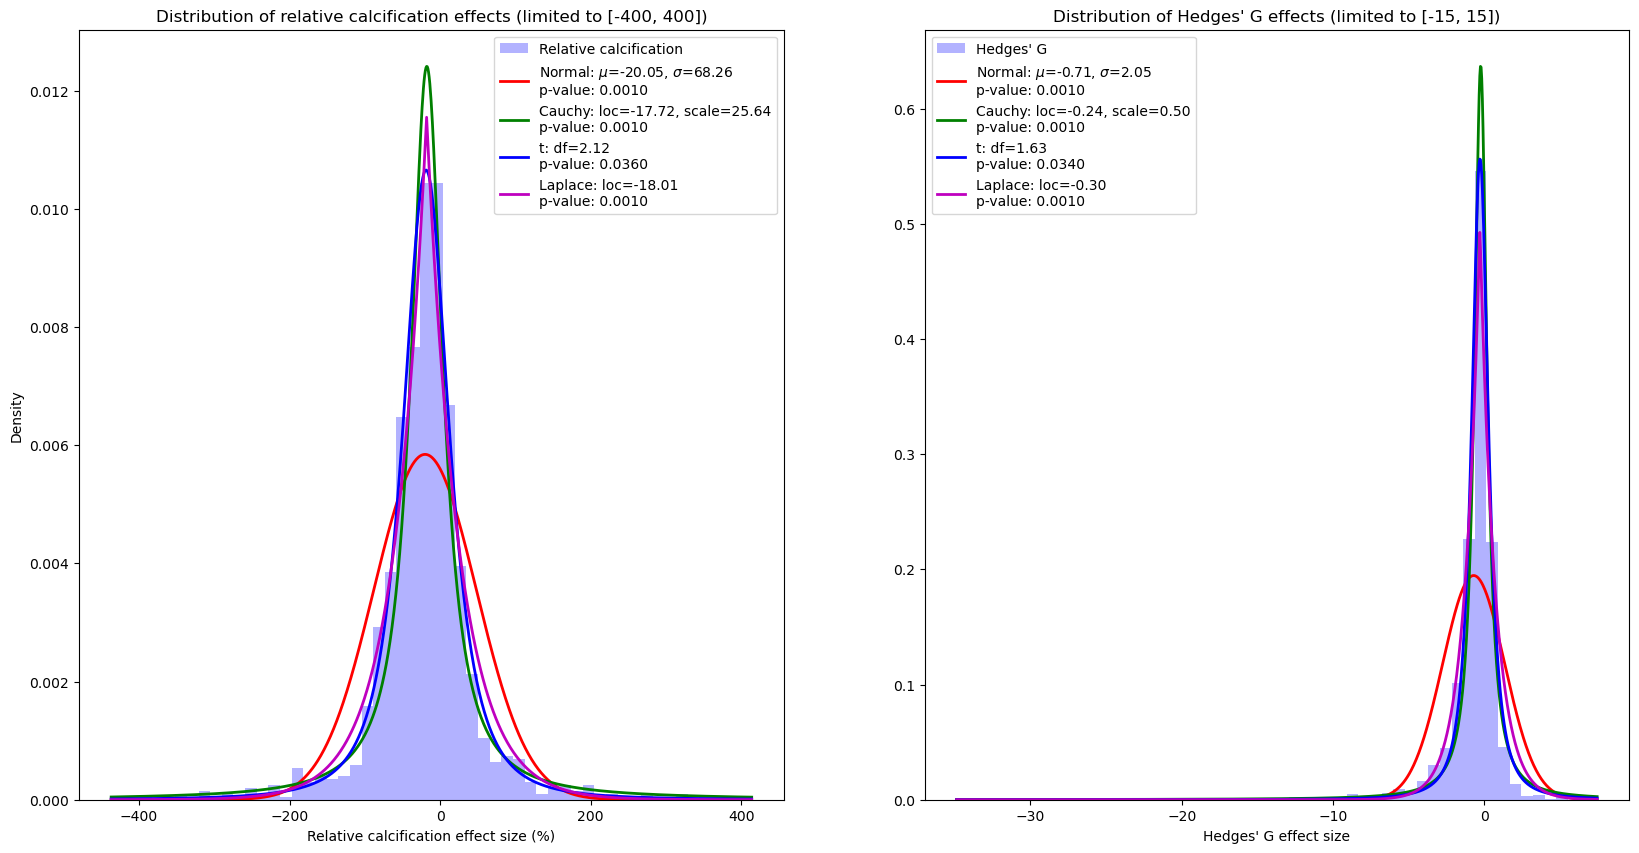

In [252]:
fig, (ax_relative, ax_hedges) = plt.subplots(1,2,figsize=(20,10))

relative_calcification_lims = [-400, 400]
effect_lims = [-15, 15]
limited_raw = test[(test.relative_calcification > relative_calcification_lims[0]) & (test.relative_calcification < relative_calcification_lims[1])]

bins = 50
n_mc_samples = 1000

# fit a normal distribution to the data
from scipy.stats import norm, cauchy, t, laplace, shapiro, anderson, goodness_of_fit

def fit_distributions(ax, data, relative_calcification_lims, n_mc_samples=1000):
    # Fit normal distribution
    mu, std = norm.fit(data)
    # Fit Cauchy distribution
    loc, scale = cauchy.fit(data)
    # Fit Student's t distribution (with 3 degrees of freedom for heavy tails)
    df, t_loc, t_scale = t.fit(data)
    # Fit Laplace distribution
    lap_loc, lap_scale = laplace.fit(data)

    # Plot the fitted distributions
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 1000)


    # test for goodness of fit for likely distributions
    norm_gof = goodness_of_fit(norm, limited_raw.relative_calcification, n_mc_samples=n_mc_samples)
    cauchy_gof = goodness_of_fit(cauchy, limited_raw.relative_calcification, n_mc_samples=n_mc_samples)
    t_gof = goodness_of_fit(t, limited_raw.relative_calcification, n_mc_samples=n_mc_samples)
    laplace_gof = goodness_of_fit(laplace, limited_raw.relative_calcification, n_mc_samples=n_mc_samples)
    
    # Plot normal distribution
    p_norm = norm.pdf(x, mu, std)
    ax.plot(x, p_norm, 'r', linewidth=2, label=f'Normal: $\\mu$={mu:.2f}, $\\sigma$={std:.2f}\np-value: {float(norm_gof.pvalue):.04f}')

    # Plot Cauchy distribution
    p_cauchy = cauchy.pdf(x, loc, scale)
    ax.plot(x, p_cauchy, 'g', linewidth=2, label=f'Cauchy: loc={loc:.2f}, scale={scale:.2f}\np-value: {float(cauchy_gof.pvalue):.04f}')

    # Plot t distribution
    p_t = t.pdf(x, df, t_loc, t_scale)
    ax.plot(x, p_t, 'b', linewidth=2, label=f't: df={df:.2f}\np-value: {float(t_gof.pvalue):.04f}')

    # Plot Laplace distribution
    p_lap = laplace.pdf(x, lap_loc, lap_scale)
    ax.plot(x, p_lap, 'm', linewidth=2, label=f'Laplace: loc={lap_loc:.2f}\np-value: {float(laplace_gof.pvalue):.04f}')


ax_relative.hist(limited_raw.relative_calcification, bins=bins, density=True, alpha=0.3, color='b', label='Relative calcification')
fit_distributions(ax_relative, limited_raw.relative_calcification.dropna(), relative_calcification_lims, n_mc_samples=n_mc_samples)
ax_relative.set_title(f"Distribution of relative calcification effects (limited to [{relative_calcification_lims[0]}, {relative_calcification_lims[1]}])")
ax_relative.set_xlabel("Relative calcification effect size (%)")

ax_hedges.hist(limited_raw.hedges_g, bins=bins, density=True, alpha=0.3, color='b', label="Hedges' G")
fit_distributions(ax_hedges, limited_raw.hedges_g.dropna(), effect_lims, n_mc_samples=n_mc_samples)
ax_hedges.set_title(f"Distribution of Hedges' G effects (limited to [{effect_lims[0]}, {effect_lims[1]}])")
ax_hedges.set_xlabel("Hedges' G effect size")

ax_relative.set_ylabel("Density")
for ax in [ax_hedges, ax_relative]:
    ax.legend()

Text(0, 0.5, 'Frequency')

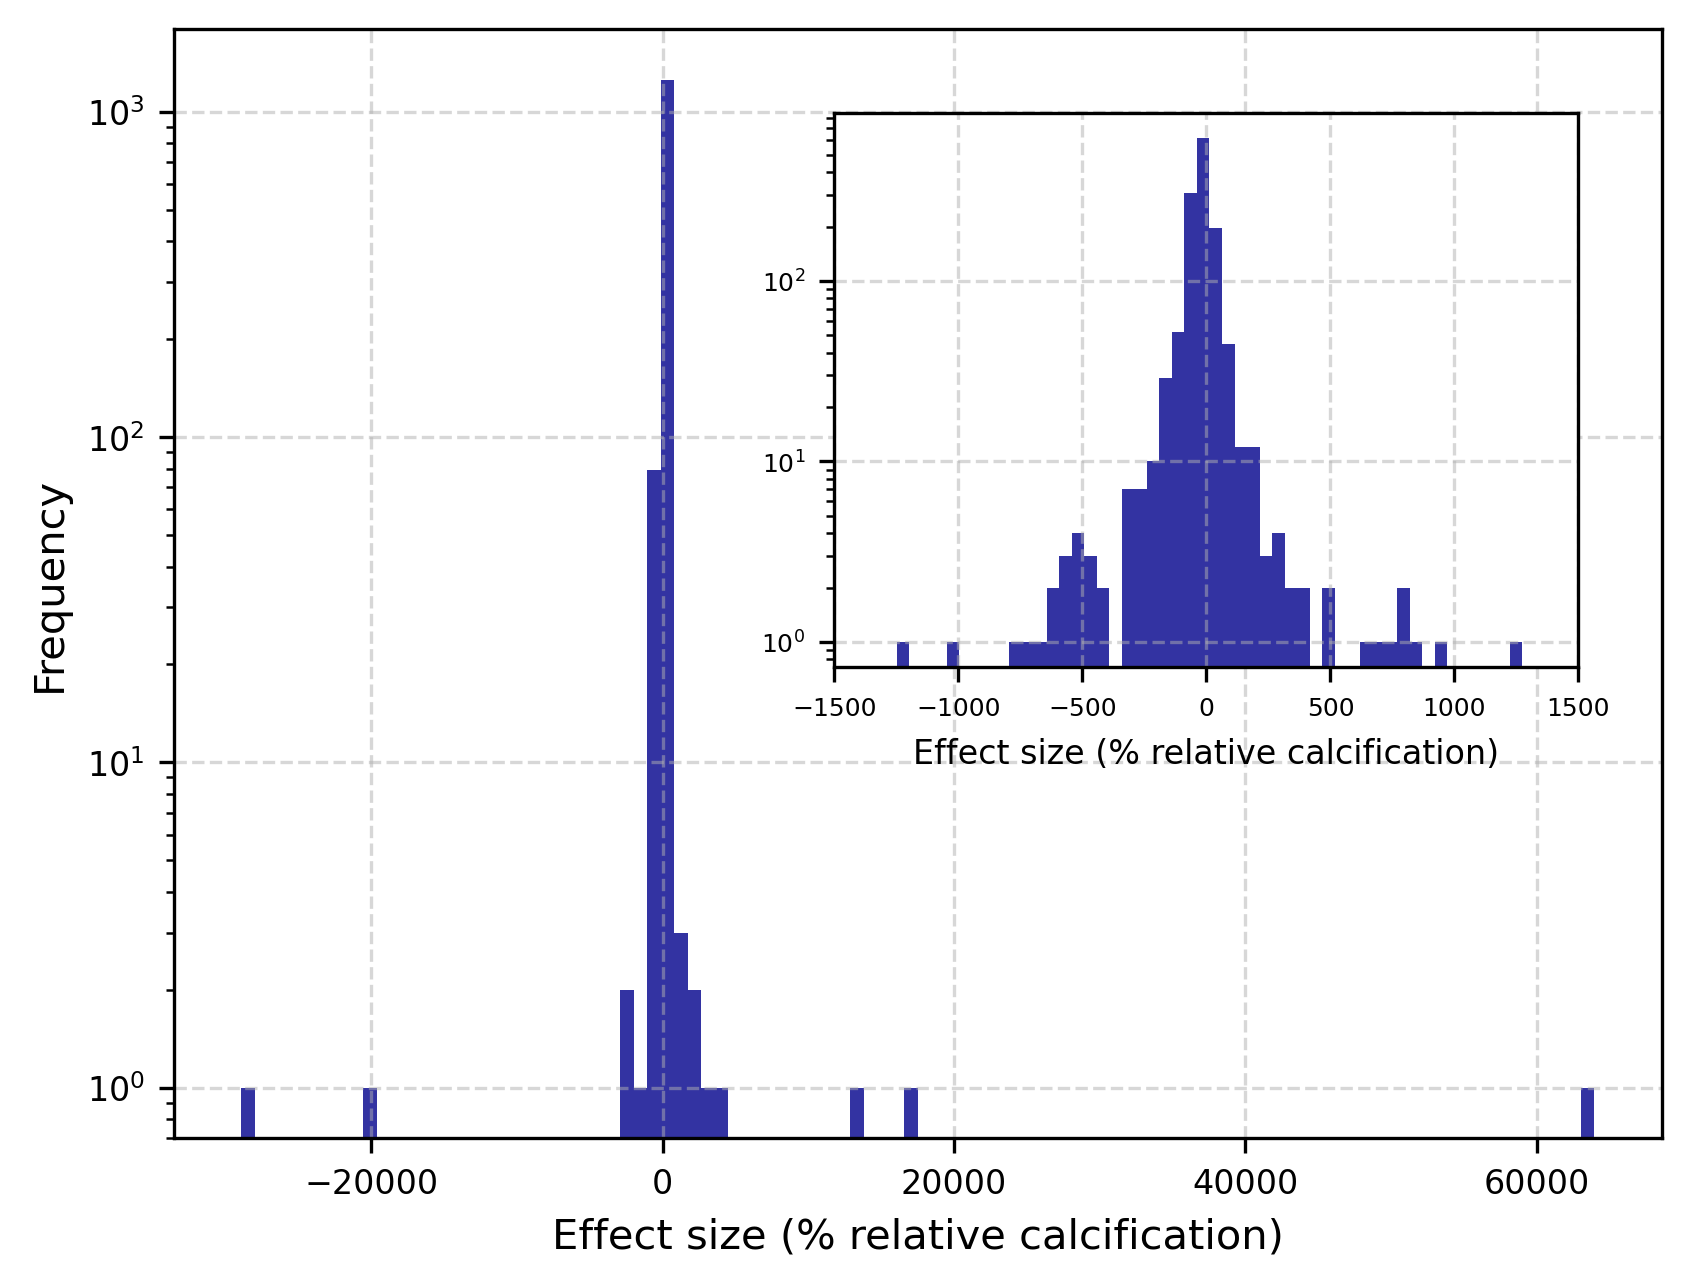

In [257]:
inset_lims = [-1500, 1500]
fig, ax = plt.subplots(dpi=300)
ax.hist(test.relative_calcification, bins=100, color="darkblue", alpha=0.8)
ax.set_yscale('log')

inset_data = test.relative_calcification[(test.relative_calcification >= min(inset_lims)) & (test.relative_calcification <= max(inset_lims))]
inset_ax = inset_axes(ax, width="50%", height="50%", loc='upper right', borderpad=2)
inset_ax.tick_params(axis='both', which='major', labelsize=6)
inset_ax.hist(inset_data, bins=50, color="darkblue", alpha=0.8)
inset_ax.set_xlim(-1500, 1500)
inset_ax.set_yscale('log')

[a.grid(True, linestyle='--', alpha=0.5) for a in fig.axes]

ax.tick_params(labelsize=8)
ax.set_xlabel('Effect size (% relative calcification)')
inset_ax.set_xlabel('Effect size (% relative calcification)', fontsize=8)
ax.set_ylabel('Frequency')

# Adding climatology

In [258]:
# count number of non-nan values in doi column
print(f"Number of non-null DO values: {carb_df.do.count()}")
# select dois with do values
dois_with_do = carb_df[carb_df.do.notnull()]
print(f"Number of rows with non-null DO values: {len(dois_with_do)}")
print(f"Number of unique DOIs with DO values: {dois_with_do.doi.nunique()}")

# Display a sample of these DOIs with their DO values
print("\nSample of DOIs with DO values:")
dois_with_do[['doi', 'do']].doi.value_counts()


NameError: name 'carb_df' is not defined

In [ ]:
save_cols = utils.read_yaml(config.resources_dir / "mapping.yaml")["save_cols"]
# # save results
results_df['year'] = pd.to_datetime(results_df['year']).dt.strftime('%Y')   # cast year from pd.timestamp to integer
results_df[save_cols].to_csv(config.tmp_data_dir / "results.csv", index=False)
# pH
results_ph = results_df[results_df['treatment'] == 'phtot'].reset_index(drop=True)
results_ph['ID'] = results_ph.index
# temp
results_temp = results_df[results_df['treatment'] == 't_in'].reset_index(drop=True)
results_temp['ID'] = results_temp.index

# results_df.to_csv(config.tmp_data_dir / "results.csv")
# results_temp.to_csv(config.tmp_data_dir / "results_t_in.csv")
# results_ph.to_csv(config.tmp_data_dir / "results_phtot.csv")
results_temp[save_cols + ['ID']].to_csv(config.tmp_data_dir / "results_t_in.csv")
results_ph[save_cols + ['ID']].to_csv(config.tmp_data_dir / "results_phtot.csv")

## Python-native meta-analysis

/Users/rt582/miniforge3/envs/calcer/lib/python3.13/site-packages/statsmodels/stats/meta_analysis.py:105: UserWarning: `use_t=True` requires `nobs` for each sample or `ci_func`. Using normal distribution for confidence interval of individual samples.
  warnings.warn(msg)


                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                  0.000000  0.571250 -1.119630  1.119630  0.000984  0.001410
1                 -4.067009  1.073944 -6.171900 -1.962118  0.000278  0.000630
2                 -4.259911  1.110706 -6.436856 -2.082966  0.000260  0.000598
3                 -0.572777  0.585432 -1.720202  0.574648  0.000937  0.001376
4                  0.730749  0.717148 -0.674834  2.136333  0.000624  0.001100
...                     ...       ...       ...       ...       ...       ...
717               -0.223059  0.617399 -1.433139  0.987021  0.000842  0.001303
fixed effect      -0.311154  0.017916 -0.346329 -0.275979  1.000000       NaN
random effect     -0.441838  0.030709 -0.502129 -0.381548       NaN  1.000000
fixed effect wls  -0.311154  0.028254 -0.366624 -0.255683  1.000000       NaN
random effect wls -0.441838  0.038073 -0.516586 -0.367090       NaN  1.000000

[721 rows x 6 columns]


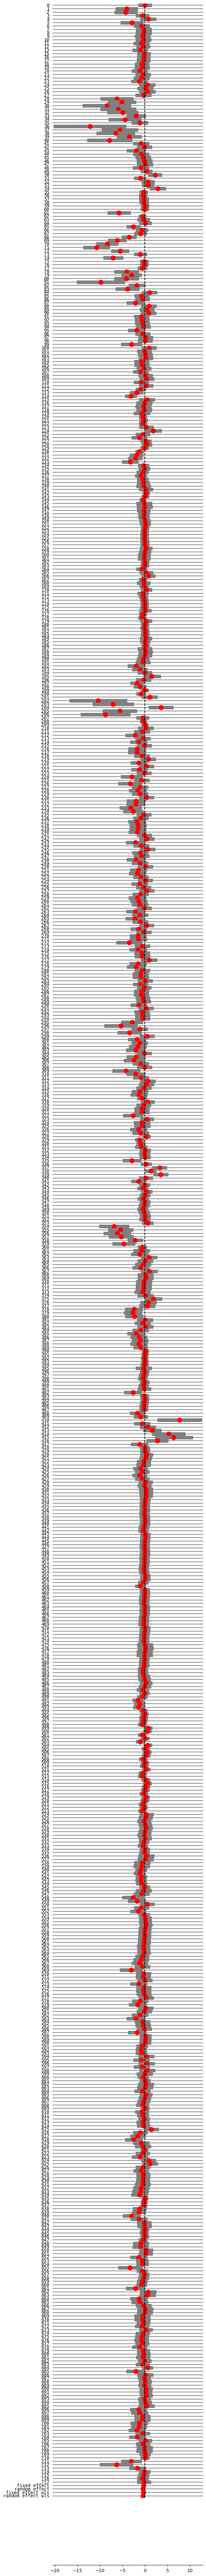

In [ ]:
import statsmodels.stats.meta_analysis as sma
# drop nas (shouldn't be necessary)
results_ph = results_ph.dropna(subset=['hedges_g', 'hedges_g_var'])

# filter
res = sma.combine_effects(pd.to_numeric(results_ph.hedges_g, errors="coerce"), pd.to_numeric(results_ph.hedges_g_var, errors="coerce"), method_re="chi2", use_t=True, row_names=results_ph.ID)

print(res.summary_frame())
# fig, ax = plt.subplots(figsize=(3,40))
fig = res.plot_forest()
fig.set_figheight(100)
fig.set_figwidth(6)
# plot a line at 0
plt.axvline(x=0, color='k', linestyle='--')

                        eff    sd_eff    ci_low    ci_upp      w_fe      w_re
0                  0.000000  0.571250 -1.119630  1.119630  0.000984  0.001452
1                 -4.067009  1.073944 -6.171900 -1.962118  0.000278  0.000894
2                 -4.259911  1.110706 -6.436856 -2.082966  0.000260  0.000862
3                 -0.572777  0.585432 -1.720202  0.574648  0.000937  0.001434
4                  0.730749  0.717148 -0.674834  2.136333  0.000624  0.001271
...                     ...       ...       ...       ...       ...       ...
717               -0.223059  0.617399 -1.433139  0.987021  0.000842  0.001394
fixed effect      -0.311154  0.017916 -0.346269 -0.276038  1.000000       NaN
random effect     -0.519677  0.043883 -0.605686 -0.433668       NaN  1.000000
fixed effect wls  -0.311154  0.028254 -0.366531 -0.255777  1.000000       NaN
random effect wls -0.519677  0.043883 -0.605686 -0.433668       NaN  1.000000

[721 rows x 6 columns]


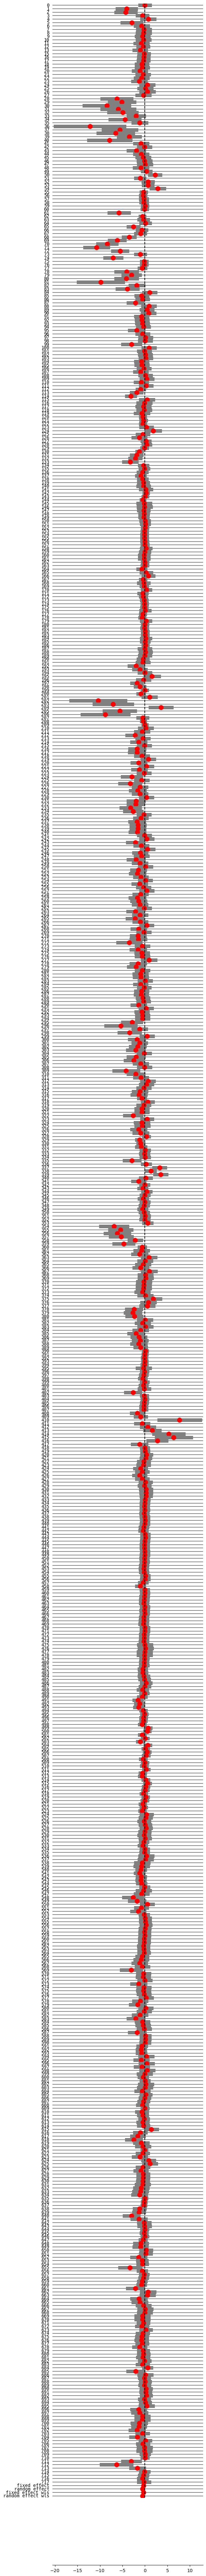

In [ ]:
import statsmodels.stats.meta_analysis as sma


# drop nas (shouldn't be necessary)
results_ph = results_ph.dropna(subset=['hedges_g', 'hedges_g_var'])
res = sma.combine_effects(pd.to_numeric(results_ph.hedges_g, errors="coerce"), pd.to_numeric(results_ph.hedges_g_var, errors="coerce"), method_re="iterated", use_t=False, row_names=results_ph.ID)

print(res.summary_frame())
# fig, ax = plt.subplots(figsize=(3,40))
fig = res.plot_forest()
fig.set_figheight(100)
fig.set_figwidth(6)
# plot a line at 0
plt.axvline(x=0, color='k', linestyle='--')

## Additional

In [ ]:
### merge results with climatology data
matched_df = results_df.set_index('doi').merge(climatology_df, left_index=True, right_index=True)   # TODO: drops ~100 rows for some reason

# define mapping of climatology variables to treatment variables
clim_var_map = {'t_in': 'MMM_30y_mean', 'phtot': 'mean_pH_30y_ensemble'}

# calculate difference between treatment and historic conditions dynamically
matched_df['clim_delta'] = matched_df.apply(
    lambda row: row['treatment_val'] - row[clim_var_map[row['treatment']]]
    if row['treatment'] in clim_var_map else np.nan,
    axis=1
)
# assign which variable to use for delta calculation
matched_df['delta_var'] = matched_df.apply(
    lambda row: row['delta_t'] if row['treatment'] == 't_in' else row['delta_pH'],
    axis=1)

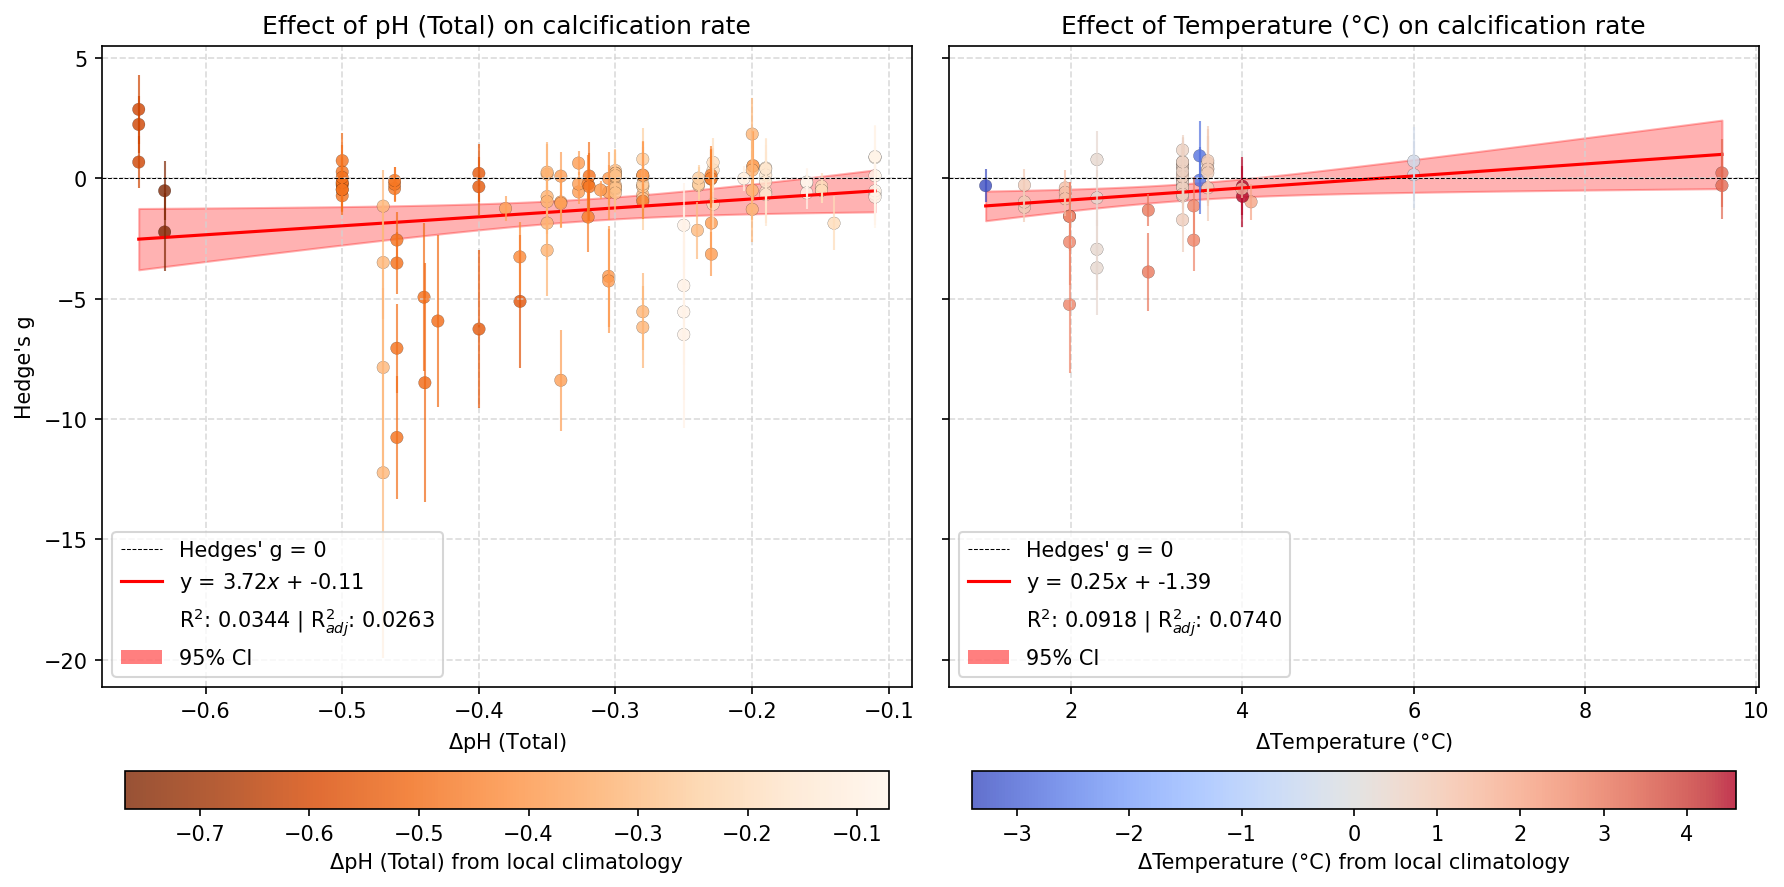

In [ ]:
import numpy as np

import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

plot_results = matched_df
plot_results = plot_results.dropna(subset=['delta_t', 'delta_pH', 'hedges_g'])

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    
    subset_df = plot_results[plot_results['treatment'] == var]
    
    subset_df = subset_df.infer_objects(copy=False).replace([np.inf, -np.inf], np.nan).dropna(subset=['hedges_g', 'delta_t', 'delta_pH'])   # remove NaNs and infinities
    delta_var = subset_df['delta_t'] if var == 't_in' else subset_df['delta_pH']
    
    # plot regression line
    summary_stats = plotting.simple_regplot(delta_var, subset_df['hedges_g'], ax=ax, line_kws={"color": "r"}, ci_kws={"color": "red"})
    
    # create colormap based on climatology delta
    if var == 'phtot':
        # for pH, larger negative changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.Oranges_r  # reverse colormap for pH
    else:  # t_in
        # for temperature, larger positive changes worse
        norm=mcolors.TwoSlopeNorm(vmin=subset_df['clim_delta'].min(), vcenter=0, vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm
    
    colors = [cmap(norm(val)) for val in subset_df['clim_delta']]

    # plot error bars with delta climatology colours
    for i, (x, y, yerr, color) in enumerate(zip(delta_var, subset_df['hedges_g'], 
                                            (subset_df['hedges_g'] - subset_df['hedges_g_l']).values, 
                                            colors)):
        ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='none', ecolor=color, alpha=0.7, lw=1)
    
    scatter = ax.scatter(delta_var, subset_df['hedges_g'],
                         c=subset_df['clim_delta'], cmap=cmap, norm=norm,
                         alpha=0.8, lw=0.1, edgecolor='black')
                         
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, pad=0.11, orientation = 'horizontal')
    cbar.set_label(f"Δ{var_name} from local climatology")

    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    ax.axhline(0, color='black', linestyle='--', lw=0.5, label='Hedges\' g = 0')
    # legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0), 1, 1, fc="red", edgecolor='none', alpha=0.5)
    ax.plot([], [], alpha=0, label=f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd
from scipy import stats
import plotly.express as px
plot_results = matched_df
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, 
                    subplot_titles=("Effect of pH (Total) on calcification rate", 
                                   "Effect of Temperature (°C) on calcification rate"))

variables = ['phtot', 't_in']
var_names = ['pH (Total)', 'Temperature (°C)']
delta_vars = ['delta_pH', 'delta_t']

# process each subplot
for i, (var, var_name, delta_var) in enumerate(zip(variables, var_names, delta_vars)):
    col = i+1  # plotly uses 1-indexed columns for some reason
    
    subset_df = plot_results[plot_results['treatment'] == var]
    
    # data cleaning (NaNs and infinities)
    subset_df = subset_df.infer_objects(copy=False).replace([np.inf, -np.inf], np.nan).dropna(subset=['hedges_g', 'delta_t', 'delta_pH'])
    # relevant variable    
    x_values = subset_df[delta_var]
    y_values = subset_df['hedges_g']
    y_error = subset_df['hedges_g'] - subset_df['hedges_g_l']
    
    # create colormap based on climatology delta
    if var == 'phtot':
        # for pH, larger negative changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm_r  # reverse colormap for pH
    else:  # t_in
        # for temperature, larger positive changes worse
        norm = mcolors.Normalize(vmin=subset_df['clim_delta'].min(), vmax=subset_df['clim_delta'].max())
        cmap = cm.coolwarm
    
    colors = [cmap(norm(val)) for val in subset_df['clim_delta']]
    
    # regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
    r_squared = r_value**2
    adjusted_r_squared = 1 - ((1 - r_squared) * (len(x_values) - 1) / (len(x_values) - 2))
    x_reg = np.linspace(min(x_values), max(x_values), 100)
    y_reg = slope * x_reg + intercept

    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg,
            mode='lines',
            line=dict(color='red'),
            name=f'y = {slope:.2f}x + {intercept:.2f}'
        ),
        row=1, col=col
    )
    # add approximated confidence interval
    ci = 1.96 * std_err  # 95% CI
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg + ci,
            mode='lines',
            line=dict(width=0),
            showlegend=False
        ),
        row=1, col=col
    )    
    fig.add_trace(
        go.Scatter(
            x=x_reg,
            y=y_reg - ci,
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor='rgba(255, 0, 0, 0.2)',
            name='95% CI'
        ),
        row=1, col=col
    )
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # add scatter points with error bars and hover text
    fig.add_trace(
        go.Scatter(
            x=x_values,
            y=y_values,
            mode='markers',
            marker=dict(
                # color=colors[0:10],  # Use the colors list generated from climatology delta
                # colors= cmap,
                size=10, 
                line=dict(width=1, color='black'), 
                opacity=0.5
            ),
            # color_continuous_scale='coolwarm',
            error_y=dict(
                type='data',
                array=y_error,
                visible=True,
                color='blue',
                thickness=1,
                width=5
            ),
            name='Data points',
            hovertemplate=
            f'Δ{var_name}: %{{x}}<br>' +
            'Hedges\' g: %{y}<br>' +
            'Treatment Calcification: %{customdata[0]:.4f}<br>' +
            'Control Calcification: %{customdata[1]:.4f}<br>' +
            'DOI: %{text}<extra></extra>',
            text=subset_df.index,
            customdata=subset_df[['treatment_calcification', 'control_calcification']]
        ),
        row=1, col=col
    )
    # add horizontal line at y=0 (Hedges g = 0)
    fig.add_trace(
        go.Scatter(
            x=[min(x_values), max(x_values)],
            y=[0, 0],
            mode='lines',
            line=dict(color='black', width=1, dash='dash'),
            name="Hedges' g = 0"
        ),
        row=1, col=col
    )


fig.update_layout(
    width=1200,
    height=600,
    template="plotly_white",
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=-.2,
        xanchor="right",
        x=1
    )
)

# Update x and y axis labels
for i in range(2):
    fig.update_xaxes(title_text=f"Δ{var_names[i]}", row=1, col=i+1, gridcolor='lightgrey')

fig.update_yaxes(title_text="Hedges' g", row=1, col=1, gridcolor='lightgrey')

# Show the figure
fig.show()

# Main analysis


### Basic plotting of result

NameError: name 'subset' is not defined

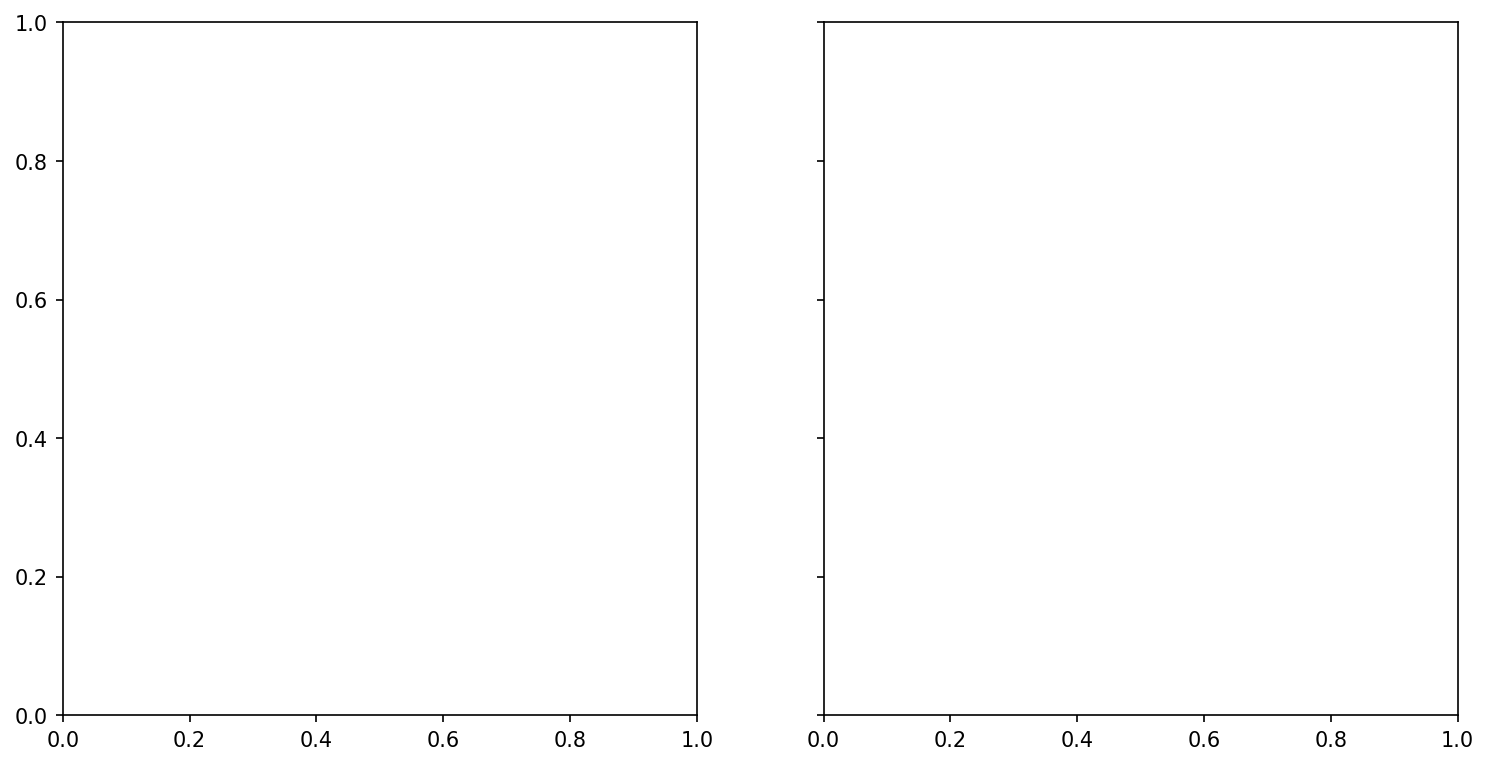

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

# plot_results = results_df[results_df.multi_var==1]
plot_results = results_df

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    # subset = results_df[results_df.multi_var==1][results_df[results_df.multi_var==1]['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])  # remove any rows containing nans
    
    # plot regression line
    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # # Plot error bars **matching scatter point colors**
    # for i, (x, y, yerr, color) in enumerate(zip(subset['delta_var'], subset['hedges_g'], 
    #                                             (subset['hedges_g'] - subset['hg_ci_l']).values, 
    #                                             colors)):
    #     ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='o', color=color, alpha=1, lw=1)

    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c="blue",
                         alpha=0.8, lw=0.1, edgecolor='black')

    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    ax.axhline(0, color='black', linestyle='--', lw=0.5, label='Hedges\' g = 0')
    # setting up legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none', alpha=0.5)
    ax.plot([],[],alpha=0,label = f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

In [ ]:
# Match by DOI the Hedges' g results with the climatology data
# matched_df = results_df.join(climatology_df, how="left", rsuffix="_clim")
matched_df = results_df.merge(climatology_df, left_index=True, right_index=True)

# Define mapping of climatology variables to treatment variables
clim_var_map = {'t_in': 'MMM_30y_mean', 'phtot': 'mean_pH_30y_ensemble'}

# Calculate difference between treatment and historic conditions dynamically
matched_df['clim_delta'] = matched_df.apply(
    lambda row: row['treatment_val'] - row[clim_var_map[row['variable']]]
    if row['variable'] in clim_var_map else np.nan,
    axis=1
)

In [ ]:
# set(climatology_df.index) - set(carb_df['doi'].unique())
set(climatology_df.index) - set(results_df.index)


In [ ]:
print(len(matched_df))
print(matched_df.clim_delta.isna().sum())

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])  # remove any rows containing nans
    
    cmap = cm.coolwarm
    norm = mcolors.Normalize(vmin=subset['clim_delta'].min(), vmax=subset['clim_delta'].max())
    colors = [cmap(norm(val)) for val in subset['clim_delta']]

    # Plot error bars **matching scatter point colors**
    for i, (x, y, yerr, color) in enumerate(zip(subset['delta_var'], subset['hedges_g'], 
                                                (subset['hedges_g'] - subset['hg_ci_l']).values, 
                                                colors)):
        ax.errorbar(x, y, yerr=[[yerr], [yerr]], fmt='o', color=color, alpha=1, lw=1)

    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c=subset['clim_delta'], cmap=cmap, norm=norm, 
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend
    c, m = summary_stats.params
    ax.plot([],[], c='red', label=f"y = {m:.2f}$x$ + {c:.2f}")
    alpha_patch = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none', alpha=0.5)
    ax.plot([],[],alpha=0,label = f"R$^2$: {summary_stats.rsquared:.4f} | R$^2_{{adj}}$: {summary_stats.rsquared_adj:.4f}")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(alpha_patch)
    labels.append("95% CI")
    ax.legend(handles, labels)
    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()

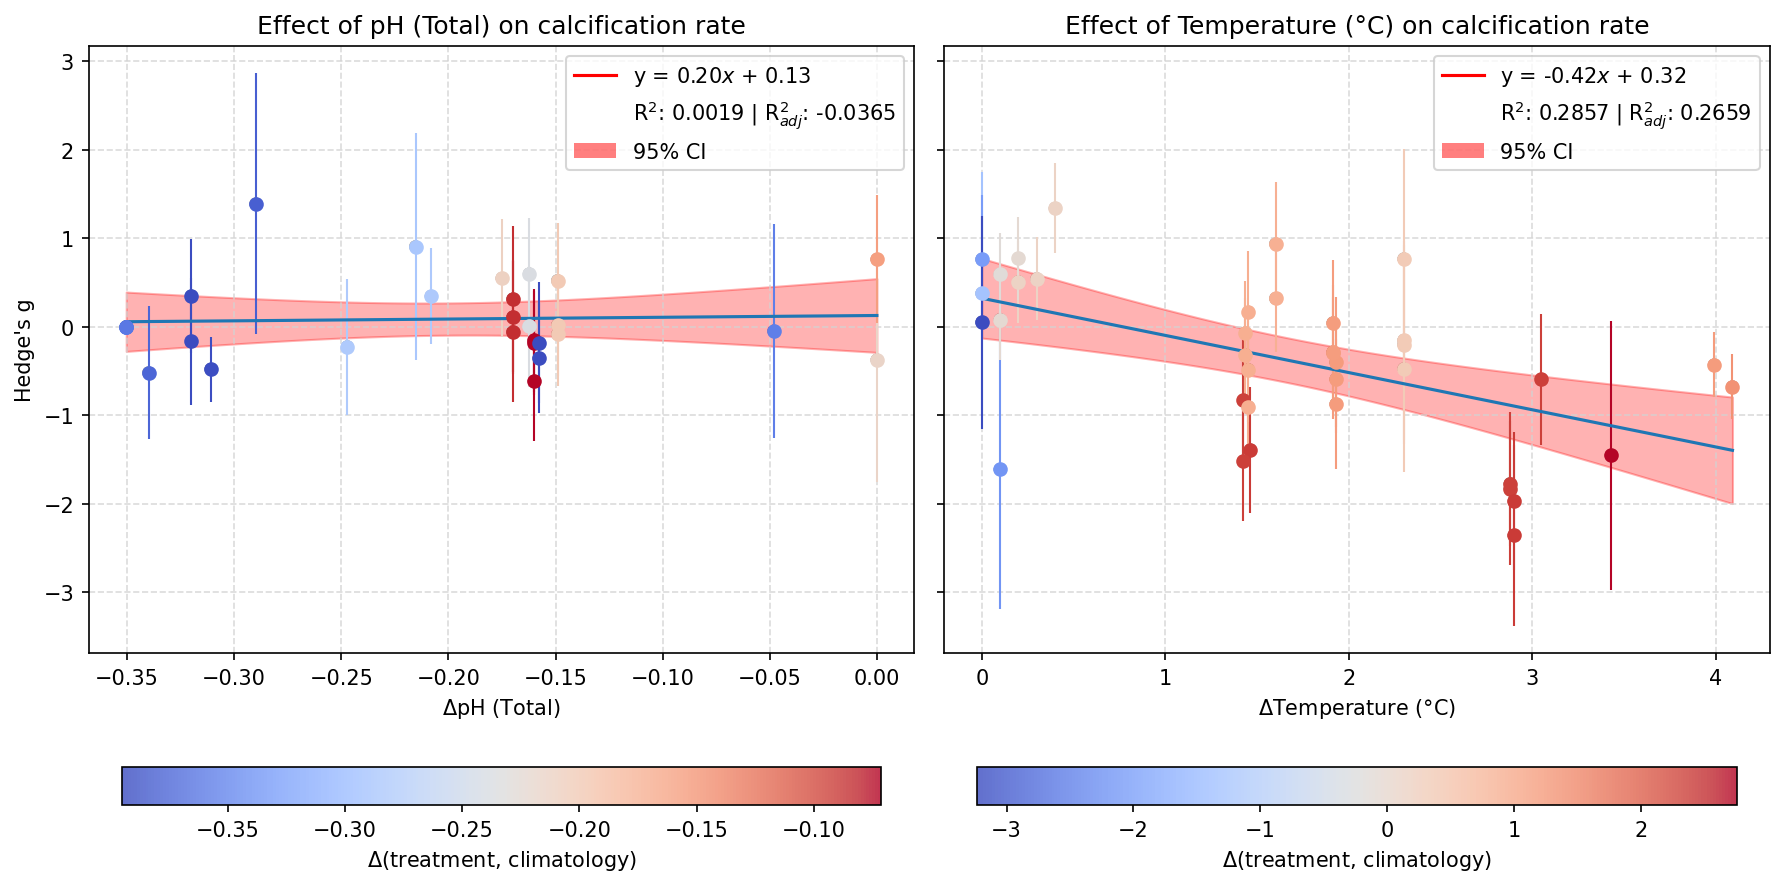

In [ ]:
sel_cols = ['species_types', 'treatment_group', 'phtot', 't_in', 'irr', 'calcification', 'calcification_sd', 'n']
study_df[sel_cols]

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

fig, (ax_ph, ax_t) = plt.subplots(1, 2, figsize=(12, 6), dpi=150, sharey=True)

for var, var_name in zip(['phtot', 't_in'], ['pH (Total)', 'Temperature (°C)']):
    ax = ax_ph if var == 'phtot' else ax_t
    subset = matched_df[matched_df['variable'] == var].dropna(subset=['delta_var', 'hedges_g'])        # remove any rows containing nans
    


    # Scatter plot with color mapping
    scatter = ax.scatter(subset['delta_var'], subset['hedges_g'], 
                         c='blue',
                         alpha=0.8, lw=0.1, edgecolor='black')

    summary_stats = plotting.simple_regplot(subset['delta_var'], subset['hedges_g'], ax=ax, ci_kws={"color": "red"})
    # add colourbar for clim_delta
    cbar = plt.colorbar(scatter, ax=ax, fraction=0.05, orientation="horizontal")
    cbar.set_label(f"$\\Delta$(treatment, climatology)")
    
    # formatting
    ax.grid(c='lightgrey', linestyle='--', alpha=0.8)
    ax.set_ylabel("")
    ax.set_xlabel(f"$\\Delta${var_name}")
    ax.set_title(f"Effect of {var_name} on calcification rate")
    # setting up legend

    
ax_ph.set_ylabel("Hedge's g")
plt.tight_layout()